# Badminton Data Analysis

Due to recently proposed scoring system change from 3x21 to 5x11 rally point system, I like to investigate on how the result will change if the system is implemented earlier. In this notebook, I will use dataset of badminton matches across 88 different BWF World Tour competition from 2018 to 2021 that I got from kaggle dataset down below.

Data Source : https://www.kaggle.com/sanderp/badminton-bwf-world-tour

In [1]:
import pandas as pd 
import numpy as np
import missingno as msno
import plotly.express as px 

In [2]:
def filter_retired(df):
    '''
    Filter out match that is not completed or retired match 
    '''
    
    df = df.copy()
    
    #filter out retired games
    df = df[df['retired']==False]
    df.reset_index(inplace=True)
    df.drop(columns='index',inplace=True)
    
    return df

In [3]:
def extract_team_nationality(df):
    '''
    Extract nationality from the team with same nationality
    '''
    
    #check if there player pair with different nationality
    if (df[((df['team_one_player_one_nationality'])!=(df['team_one_player_two_nationality']))|
           ((df['team_two_player_one_nationality'])!=(df['team_two_player_two_nationality']))].shape[0]) != 0:
        
        print('There player pair with different nationality !')
        
    
    else:
        #create only one variable of team nationality
        df.loc[:,'team_one_nationalities'] = df['team_one_player_one_nationality']
        df.loc[:,'team_two_nationalities'] = df['team_two_player_one_nationality']

        df.drop(columns=['team_one_player_one_nationality','team_one_player_two_nationality',
                         'team_two_player_one_nationality','team_two_player_two_nationality'],inplace=True)
        
    return df

In [4]:
def player_pair_summary(df):
    '''
    Make a column for player pair summary
    '''
    
    #create only one variable for player pair
    df.loc[:,'team_one_players'] = df['team_one_player_one'] + '/' + df['team_one_player_two']
    df.loc[:,'team_two_players'] = df['team_two_player_one'] + '/' + df['team_two_player_two']
    
    #drop columns that won't be used on analysis for simplicity
    df.drop(columns=['team_one_player_one','team_one_player_two',
                     'team_two_player_one', 'team_two_player_two'],inplace=True)
    
    return df

In [5]:
def game_score_summary_21pts(df):
    '''
    create game score summary on 3 x 21 points based system
    '''
    
    #create one column for game score summary
    df.loc[df['nb_sets']==2,'21pts_game_score'] = df['game_1_score'] + ',' + df['game_2_score']
    df.loc[df['nb_sets']==3,'21pts_game_score'] = df['game_1_score'] + ',' + df['game_2_score'] + ',' + \
                                                  df['game_3_score']
    
    #create column of lists consists of 21 points game score
    df['21pts_game_score'] = df['21pts_game_score'].str.split(',')
    
    #rename some columns
    df.rename(columns={'winner':'21pts_winner',
                       'game_1_score':'21pts_game_1_score',
                       'game_2_score':'21pts_game_2_score',
                       'game_3_score':'21pts_game_3_score'}, inplace=True)
    
    return df

In [6]:
def simplify_columns(df):
    '''
    drop the unused columns in the dataset
    '''
    
    #drop columns that won't be used on analysis for simplicity
    df.drop(columns=['team_one_total_points', 'team_two_total_points',
                     'team_one_most_consecutive_points', 'team_two_most_consecutive_points',
                     'team_one_game_points', 'team_two_game_points',
                     'team_one_most_consecutive_points_game_1','team_two_most_consecutive_points_game_1',
                     'team_one_game_points_game_1', 'team_two_game_points_game_1',
                     'team_one_most_consecutive_points_game_2','team_two_most_consecutive_points_game_2',
                     'team_one_game_points_game_2', 'team_two_game_points_game_2',
                     'team_one_most_consecutive_points_game_3','team_two_most_consecutive_points_game_3',
                     'team_one_game_points_game_3', 'team_two_game_points_game_3'],inplace=True)
    
    return df

In [7]:
def visualize_missing_value(df):
    '''
    visualize the missing value by using missingno library
    '''
    msno.bar(df);
    
    msno.matrix(df);

In [8]:
def interval_score(score_column):
    '''
    extract score on interval (11 points) on a single game
    '''
    for score in score_column:
        if '11' in score:
            score_11 = score.strip("'] [ ")
            return score_11
            break

In [9]:
def get_winner(game_score):
    '''
    to get the winner of the match
    '''
    team_1 = 0
    team_2 = 0
    
    for score in game_score:
        team_1_score = int(score.split('-')[0])
        team_2_score = int(score.split('-')[1])
        if team_1_score > team_2_score:
            team_1 += 1
        else:
            team_2 += 1
    
    #if team 1 win
    if team_1 > team_2:
        return 1
    #if team 2 win
    elif team_2 > team_1:
        return 2
    #for inconclusive result
    else:
        return 0

In [10]:
def game_score_summary_11pts(df):
    '''
    create game score summary on 3 x 11 points based system
    '''
    
    #extract game 1 score
    elv_score_series_1 = pd.Series(dtype='string')

    for i in range(0,len(df['game_1_scores'])):
        score_list = interval_score(df['game_1_scores'].str.split(',')[i])
        elv_pts_score = pd.Series(score_list)
        elv_score_series_1 = elv_score_series_1.append(elv_pts_score,ignore_index=True)

    df['11pts_game_1_score'] = elv_score_series_1
    
    #extract game 2 score
    elv_score_series_2 = pd.Series(dtype='string')

    for i in range(0,len(df['game_2_scores'])):
        score_list = interval_score(df['game_2_scores'].str.split(',')[i])
        elv_pts_score = pd.Series(score_list)
        elv_score_series_2 = elv_score_series_2.append(elv_pts_score,ignore_index=True)

    df['11pts_game_2_score'] = elv_score_series_2
    
    #extract game 3 score
    elv_score_series_3 = pd.Series(dtype='string')

    for i in range(0,len(df['game_3_scores'])):
        if df['nb_sets'][i] == 3:
            score_list = interval_score(df['game_3_scores'].str.split(',')[i])
            elv_pts_score = pd.Series(score_list)
            elv_score_series_3 = elv_score_series_3.append(elv_pts_score,ignore_index=True)
        else:
            elv_pts_score = pd.Series(str('NaN'))
            elv_score_series_3 = elv_score_series_3.append(elv_pts_score,ignore_index=True)

    df['11pts_game_3_score'] = elv_score_series_3
    df['11pts_game_3_score'].replace('NaN',np.NaN, inplace=True)
    
    #create one column for game score summary
    df.loc[df['nb_sets']==2,'11pts_game_score'] = df['11pts_game_1_score'] + ',' + df['11pts_game_2_score']
    df.loc[df['nb_sets']==3,'11pts_game_score'] = df['11pts_game_1_score'] + ',' + df['11pts_game_2_score'] + ',' \
                                                  + df['11pts_game_3_score']
    df['11pts_game_score'] = df['11pts_game_score'].str.split(',')
    
    #extract the winner of 11 points system
    df['11pts_winner'] = df['11pts_game_score'].apply(get_winner)
    
    return df

In [11]:
def get_winner_nationality(df,pts_system='21'):
    '''
    to get the nationality of winning team/individuals
    '''
    if pts_system == '21':
        df.loc[df['21pts_winner']==1, '21pts_winner_nationalities'] = df['team_one_nationalities']
        df.loc[df['21pts_winner']==2, '21pts_winner_nationalities'] = df['team_two_nationalities']
        
    elif pts_system == '11':
        df.loc[df['11pts_winner']==1, '11pts_winner_nationalities'] = df['team_one_nationalities']
        df.loc[df['11pts_winner']==2, '11pts_winner_nationalities'] = df['team_two_nationalities']
        #for inconclusive result
        df.loc[df['11pts_winner']==0, '11pts_winner_nationalities'] = np.nan
        
    return df

In [12]:
def evaluate_scoring_change(df):
    '''
    Evaluate the result of scoring system change
    '''
    
    #for unchanged result
    df.loc[(df['21pts_winner'])==(df['11pts_winner']),'point_change_eval'] = 'Unchanged'

    #for changed result
    df.loc[(df['21pts_winner']!=df['11pts_winner'])&(df['11pts_winner']!=0),'point_change_eval'] = 'Changed'

    #for inconclusive result 
    df.loc[(df['11pts_winner']==0),'point_change_eval'] = 'Inconclusive'
    
    return df

In [13]:
def plot_pie(df,chart_title):
    '''
    to plot pie chart about proportion of match result evaluation
    '''
    fig = px.pie(df, 
             values=df['point_change_eval'].value_counts(), 
             names=df['point_change_eval'].value_counts().index, 
             title=chart_title)
    return fig.show()

In [14]:
def plot_stacked_bar(df,by,chart_title,pct=True):
    '''
    plot stacked bar chart by customable group category
    '''
    evaluation = df.groupby(by)['point_change_eval'].value_counts()
    evaluation = evaluation.unstack('point_change_eval')

    #reorder the columns 
    col_name = ['Unchanged','Inconclusive','Changed']
    evaluation = evaluation[col_name]

    #order of display
    custom_dict = {'HSBC BWF World Tour Finals': 0, 
                   'HSBC BWF World Tour Super 1000': 1, 
                   'HSBC BWF World Tour Super 750': 2,
                   'HSBC BWF World Tour Super 500': 3,
                   'HSBC BWF World Tour Super 300': 4,
                   'HSBC BWF World Tour Super 100': 5} 

    evaluation = pd.DataFrame(evaluation.sort_index(key=lambda x:x.map(custom_dict)))

    #evaluation_percentage
    evaluation_pct = evaluation.copy()
    evaluation_pct['Unchanged'] = round(100*(evaluation['Unchanged']/(evaluation['Unchanged']+
                                    evaluation['Inconclusive']+evaluation['Changed'])),2)
    evaluation_pct['Inconclusive'] = round(100*(evaluation['Inconclusive']/(evaluation['Unchanged']+
                                         evaluation['Inconclusive']+evaluation['Changed'])),2)
    evaluation_pct['Changed'] = round(100*(evaluation['Changed']/(evaluation['Unchanged']+
                                        evaluation['Inconclusive']+evaluation['Changed'])),2)
    
    if pct==True:
        fig = px.bar(evaluation_pct,
                     title = chart_title,
                     labels={
                     "tournament_type": "Tournament Type",
                     "value": "Percentage of Games"
                     })
        return fig.show()
    
    else:
        fig = px.bar(evaluation,
                     title = chart_title,
                     labels={
                     "tournament_type": "Tournament Type",
                     "value": "Number of Games"
                     })
        return fig.show()

In [15]:
def extract_net_win(df):
    '''
    calculate the difference of numbers of win for each match between different nationality
    with changed result and grouped by each nationality
    '''
    
    #subset the match with changed result between different nationality 
    changed_diffnat = df[(df['point_change_eval']=='Changed')&
                            (df['21pts_winner_nationalities']!=df['11pts_winner_nationalities'])]
    
    #create dataframe to count winner nationality from 21 points winner 
    twenty_one_pts = pd.DataFrame(changed_diffnat['21pts_winner_nationalities'].value_counts())
    twenty_one_pts.reset_index(inplace=True)
    
    #create dataframe to count winner nationality from 11 points winner 
    eleven_pts = pd.DataFrame(changed_diffnat['11pts_winner_nationalities'].value_counts())
    eleven_pts.reset_index(inplace=True)
    
    #merge the two dataset
    net_win = pd.merge(twenty_one_pts, eleven_pts, how='inner', on='index')
    
    #calculate the net_win_changed parameter
    net_win['net_win'] = net_win['11pts_winner_nationalities'] - net_win['21pts_winner_nationalities']
    
    #calculate total match involved
    net_win['total_matches_involved'] = net_win['11pts_winner_nationalities'] + net_win['21pts_winner_nationalities']
    
    #calculate the percentage of net_win_changed from total match involved
    net_win['net_win_%'] = round(net_win['net_win']*100/net_win['total_matches_involved'],2)
    
    
    net_win.set_index('index',inplace=True)
    net_win.sort_values(by='net_win',inplace=True)
    
    return net_win

## Men's Singles

In [16]:
#Men's Singles
ms = pd.read_csv('ms.csv')

In [17]:
#filter retired match 
ms = filter_retired(ms)

#there are incomplete games I discovered in the earlier EDA
ms.drop(index=2739,inplace=True)
ms.reset_index(drop=False, inplace=True)
ms.drop(columns='index',inplace=True)

#create game score
ms = game_score_summary_21pts(ms)

#simplify columns 
ms = simplify_columns(ms)

ms

,tournament,city,country,date,tournament_type,discipline,round,21pts_winner,nb_sets,retired,...,21pts_game_2_score,21pts_game_3_score,team_one_players,team_two_players,team_one_nationalities,team_two_nationalities,game_1_scores,game_2_scores,game_3_scores,21pts_game_score
0,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,1,3,False,...,21-18,21-9,Jun Hao Leong,Kantawat Leelavechabutr,MAS,THA,"['0-0', '1-0', '2-0', '3-0', '3-1', '4-1', '4-...","['0-0', '0-1', '1-1', '1-2', '2-2', '2-3', '3-...","['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '4-...","[11-21, 21-18, 21-9]"
1,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,1,2,False,...,21-18,NaN,Teck Zhi Soo,Chico Aura Dwi Wardoyo,MAS,INA,"['0-0', '1-0', '2-0', '3-0', '4-0', '4-1', '5-...","['0-0', '1-0', '2-0', '3-0', '4-0', '5-0', '6-...",[],"[21-7, 21-18]"
2,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,1,3,False,...,8-21,23-21,Mek Narongrit,Yee Han Chong,THA,MAS,"['0-0', '1-0', '2-0', '2-1', '3-1', '4-1', '5-...","['0-0', '0-1', '0-2', '0-3', '1-3', '2-3', '2-...","['0-0', '1-0', '2-0', '3-0', '4-0', '4-1', '4-...","[21-16, 8-21, 23-21]"
3,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,1,2,False,...,21-7,NaN,Mithun Manjunath,Henrikho Kho Wibowo,IND,INA,"['0-0', '0-1', '1-1', '1-2', '2-2', '3-2', '3-...","['0-0', '1-0', '2-0', '3-0', '4-0', '5-0', '6-...",[],"[21-17, 21-7]"
4,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,2,2,False,...,13-21,NaN,Chirag Sen,Hashiru Shimono,IND,JPN,"['0-0', '1-0', '2-0', '2-1', '2-2', '2-3', '3-...","['0-0', '1-0', '2-0', '3-0', '3-1', '4-1', '4-...",[],"[13-21, 13-21]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,MS,Quarter final,2,2,False,...,15-21,NaN,Ditlev Jaeger Holm,Hans-Kristian Solberg Vittinghus,DEN,DEN,"['0-0', '0-1', '1-1', '1-2', '1-3', '1-4', '1-...","['0-0', '1-0', '2-0', '2-1', '3-1', '3-2', '3-...",[],"[11-21, 15-21]"
3686,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,MS,Quarter final,1,2,False,...,21-10,NaN,Mads Christophersen,Joran Kweekel,DEN,NED,"['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '4-...","['0-0', '1-0', '2-0', '3-0', '3-1', '4-1', '5-...",[],"[21-14, 21-10]"
3687,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,MS,Semi final,1,3,False,...,9-21,21-11,Toma Junior Popov,Kunlavut Vitidsarn,FRA,THA,"['0-0', '0-1', '0-2', '0-3', '0-4', '1-4', '2-...","['0-0', '1-0', '1-1', '1-2', '2-2', '2-3', '2-...","['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '4-...","[21-17, 9-21, 21-11]"
3688,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,MS,Semi final,2,3,False,...,13-21,12-21,Hans-Kristian Solberg Vittinghus,Mads Christophersen,DEN,DEN,"['0-0', '1-0', '2-0', '2-1', '3-1', '4-1', '4-...","['0-0', '1-0', '2-0', '3-0', '3-1', '3-2', '3-...","['0-0', '1-0', '2-0', '3-0', '4-0', '4-1', '4-...","[22-20, 13-21, 12-21]"


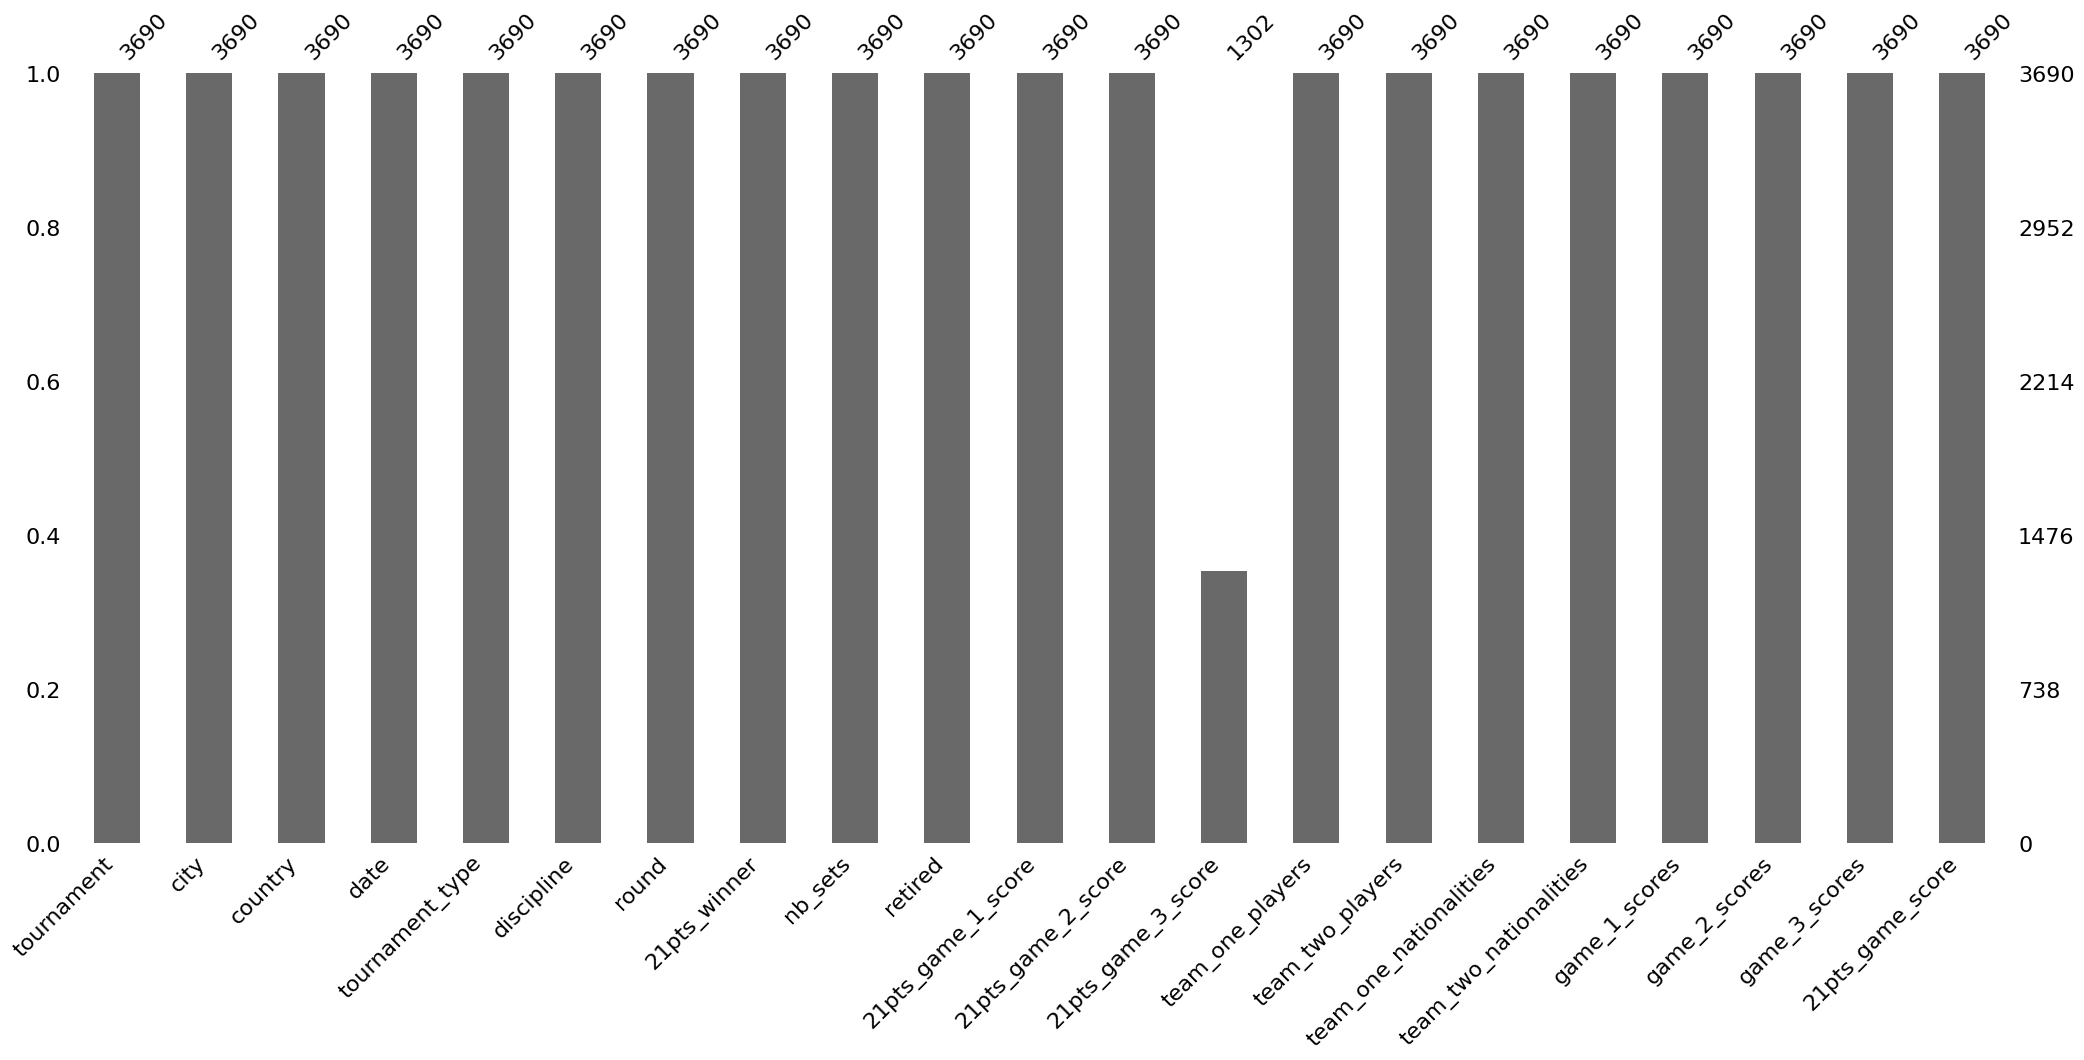

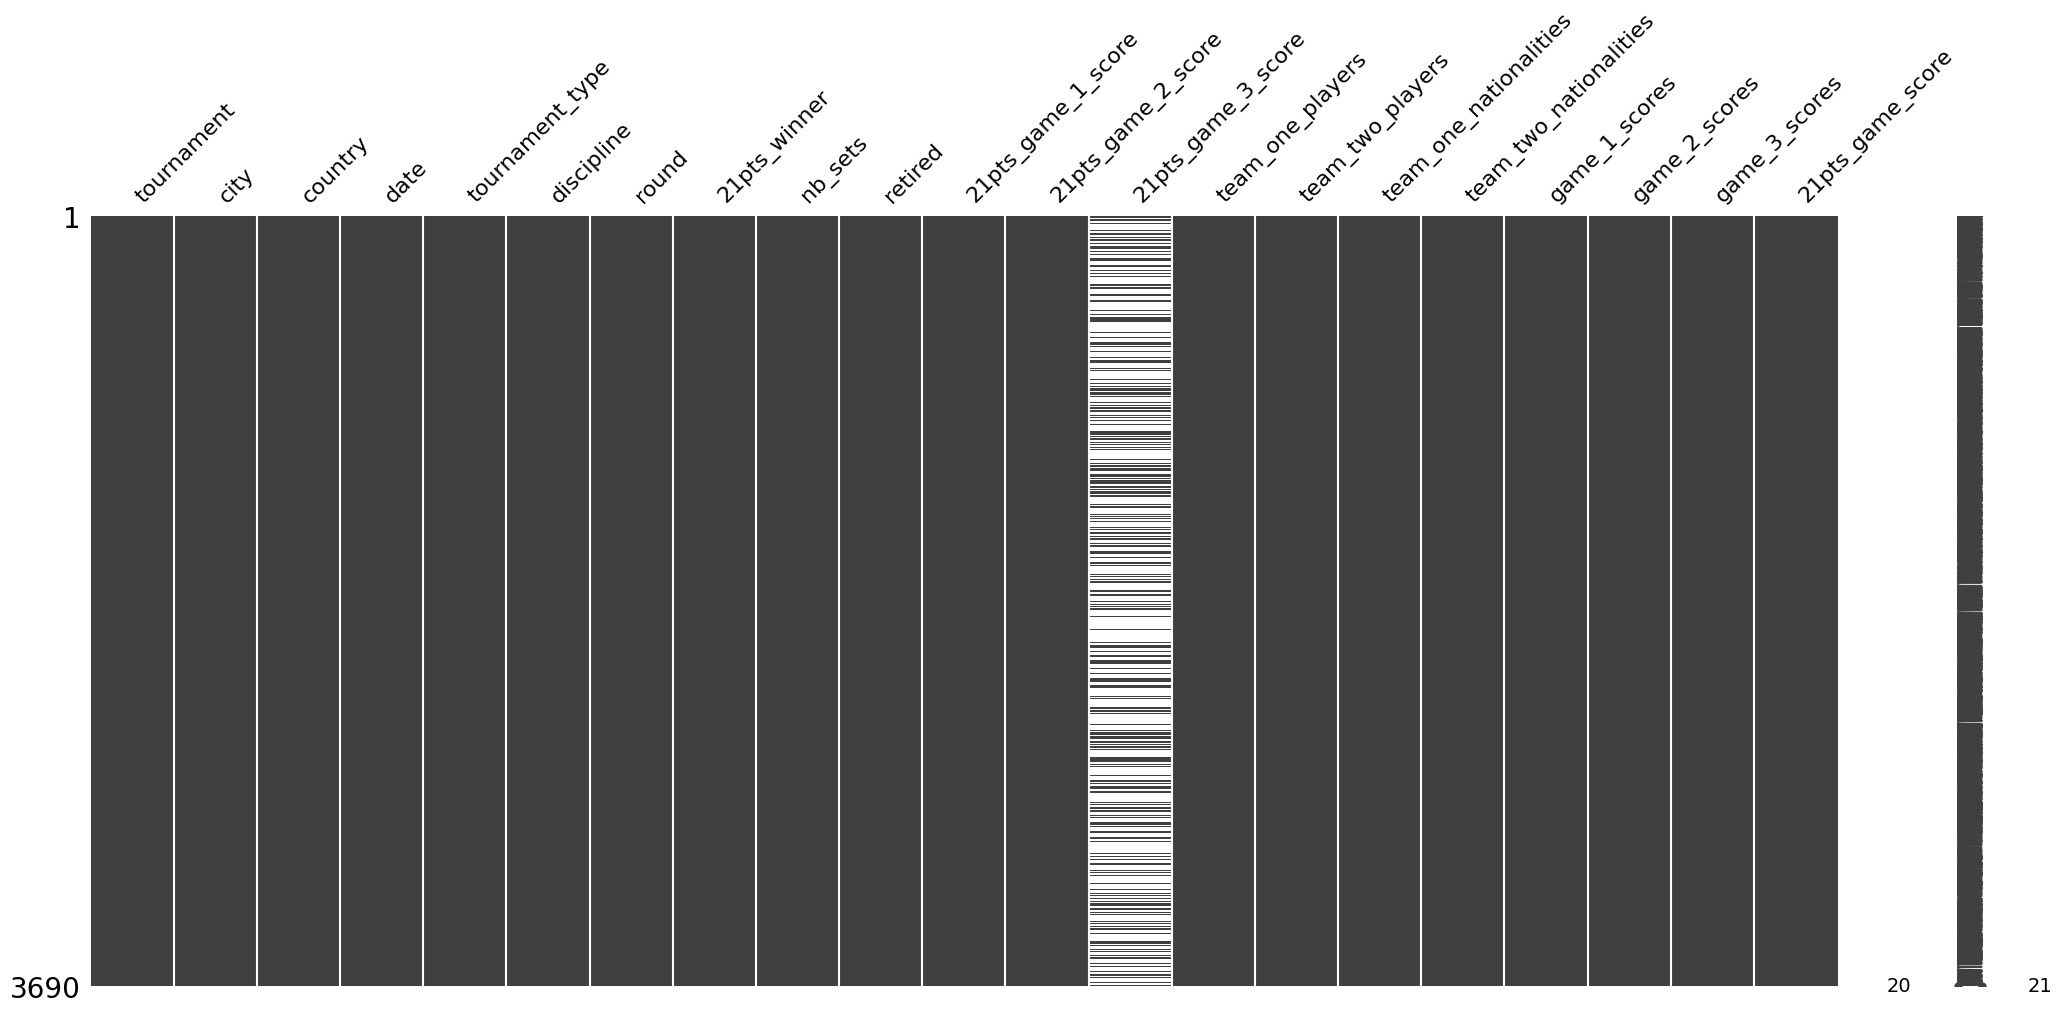

In [18]:
visualize_missing_value(ms)

In [19]:
#extract score for 11 points based system
ms = game_score_summary_11pts(ms)

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  elv_score_series_1 = elv_score_series_1.append(elv_pts_score,ignore_index=True)
/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  elv_score_series_2 = elv_score_series_2.append(elv_pts_score,ignore_index=True)
/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:33: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  elv_score_series_3 = elv_score_series_3.append(elv_pts_score,ignore_index=True)
/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:36: FutureWarning: The s

In [20]:
#get winning team nationality for 21 points 
ms = get_winner_nationality(ms,pts_system='21')

#get winning team nationality for 11 points 
ms = get_winner_nationality(ms,pts_system='11')

In [21]:
#evaluate the result of scoring system change 
ms = evaluate_scoring_change(ms)

In [22]:
plot_pie(ms,chart_title="Proportion of Men's Singles Match Affected by Change in Scoring System")

In [23]:
plot_stacked_bar(df=ms,by='tournament_type',pct=True,
                 chart_title="Men's Single Match Evaluation for Scoring System Change in each Tournament Type")

In [24]:
#calculate net_win for Men's Singles
net_win_ms = extract_net_win(ms)
net_win_ms

,21pts_winner_nationalities,11pts_winner_nationalities,net_win,total_matches_involved,net_win_%
index,,,,,
CHN,56,34,-22,90,-24.44
MAS,39,30,-9,69,-13.04
KOR,23,18,-5,41,-12.20
DEN,39,35,-4,74,-5.41
JPN,29,25,-4,54,-7.41
ESP,3,1,-2,4,-50.00
CZE,3,1,-2,4,-50.00
GER,6,5,-1,11,-9.09
BUL,3,2,-1,5,-20.00


## Women's Singles

In [25]:
#Women's Singles
ws = pd.read_csv('ws.csv')

In [26]:
#filter retired match 
ws = filter_retired(ws)

#create game score
ws = game_score_summary_21pts(ws)

#simplify columns 
ws = simplify_columns(ws)

ws

,tournament,city,country,date,tournament_type,discipline,round,21pts_winner,nb_sets,retired,...,21pts_game_2_score,21pts_game_3_score,team_one_players,team_two_players,team_one_nationalities,team_two_nationalities,game_1_scores,game_2_scores,game_3_scores,21pts_game_score
0,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,WS,Qualification quarter final,2,3,False,...,21-15,13-21,Benyapa Aimsaard,Chasinee Korepap,THA,THA,"['0-0', '1-0', '1-1', '1-2', '2-2', '2-3', '2-...","['0-0', '1-0', '2-0', '2-1', '3-1', '3-2', '4-...","['0-0', '1-0', '1-1', '2-1', '3-1', '3-2', '3-...","[17-21, 21-15, 13-21]"
1,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,WS,Qualification quarter final,2,3,False,...,7-21,6-21,Krestina Silich,Nuntakarn Aimsaard,BLR,THA,"['0-0', '1-0', '2-0', '3-0', '4-0', '4-1', '5-...","['0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '1-...","['0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '0-...","[21-16, 7-21, 6-21]"
2,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,WS,Qualification quarter final,2,2,False,...,10-21,NaN,Piramon Chamnaktan,Mattana Hemrachatanun,THA,THA,"['0-0', '1-0', '1-1', '1-2', '2-2', '3-2', '3-...","['0-0', '0-1', '1-1', '2-1', '3-1', '3-2', '4-...",[],"[8-21, 10-21]"
3,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,WS,Qualification quarter final,2,3,False,...,15-21,18-21,Supanida Katethong,Manassanan Lerthattasin,THA,THA,"['0-0', '0-1', '0-2', '1-2', '1-3', '2-3', '2-...","['0-0', '1-0', '2-0', '3-0', '3-1', '4-1', '4-...","['0-0', '1-0', '1-1', '2-1', '2-2', '2-3', '2-...","[21-17, 15-21, 18-21]"
4,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,10-01-2018,HSBC BWF World Tour Super 300,WS,Round of 32,1,2,False,...,21-12,NaN,Nitchaon Jindapol,Nuntakarn Aimsaard,THA,THA,"['0-0', '1-0', '2-0', '3-0', '3-1', '3-2', '3-...","['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '5-...",[],"[21-13, 21-12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,WS,Quarter final,2,3,False,...,21-17,19-21,Iris Wang,Saina Nehwal,USA,IND,"['0-0', '1-0', '1-1', '1-2', '1-3', '2-3', '2-...","['0-0', '1-0', '2-0', '2-1', '2-2', '3-2', '3-...","['0-0', '0-1', '1-1', '2-1', '2-2', '3-2', '4-...","[19-21, 21-17, 19-21]"
2929,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,WS,Quarter final,2,2,False,...,8-21,NaN,Ira Sharma,Line Christophersen,IND,DEN,"['0-0', '1-0', '2-0', '2-1', '2-2', '2-3', '3-...","['0-0', '0-1', '0-2', '0-3', '0-4', '1-4', '2-...",[],"[11-21, 8-21]"
2930,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,WS,Semi final,2,2,False,...,17-21,NaN,Saina Nehwal,Line Christophersen,IND,DEN,"['0-0', '1-0', '2-0', '2-1', '2-2', '3-2', '3-...","['0-0', '0-1', '1-1', '2-1', '3-1', '3-2', '3-...",[],"[17-21, 17-21]"
2931,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,WS,Semi final,2,3,False,...,15-21,18-21,Pornpawee Chochuwong,Busanan Ongbamrungphan,THA,THA,"['0-0', '0-1', '1-1', '1-2', '1-3', '1-4', '2-...","['0-0', '0-1', '0-2', '0-3', '0-4', '1-4', '1-...","['0-0', '1-0', '1-1', '2-1', '3-1', '3-2', '4-...","[21-18, 15-21, 18-21]"


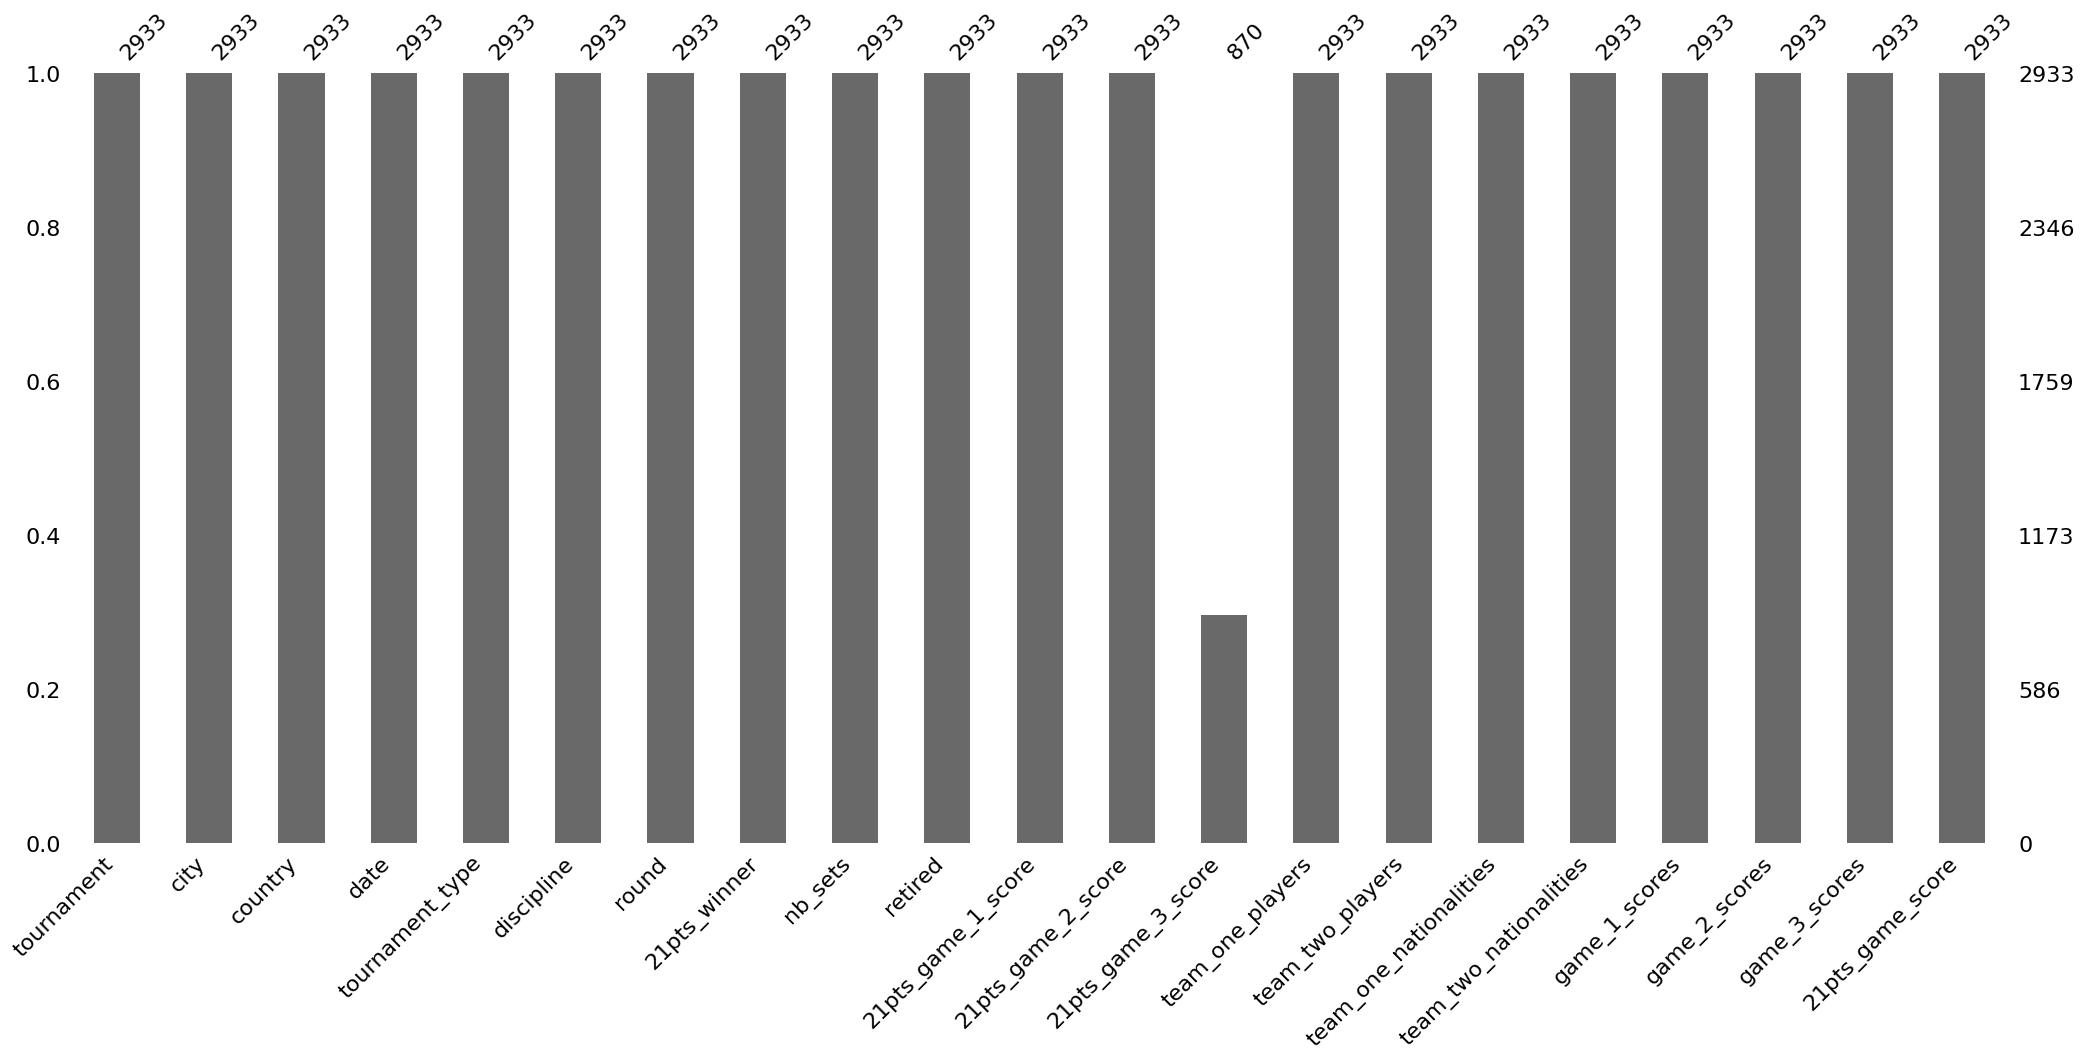

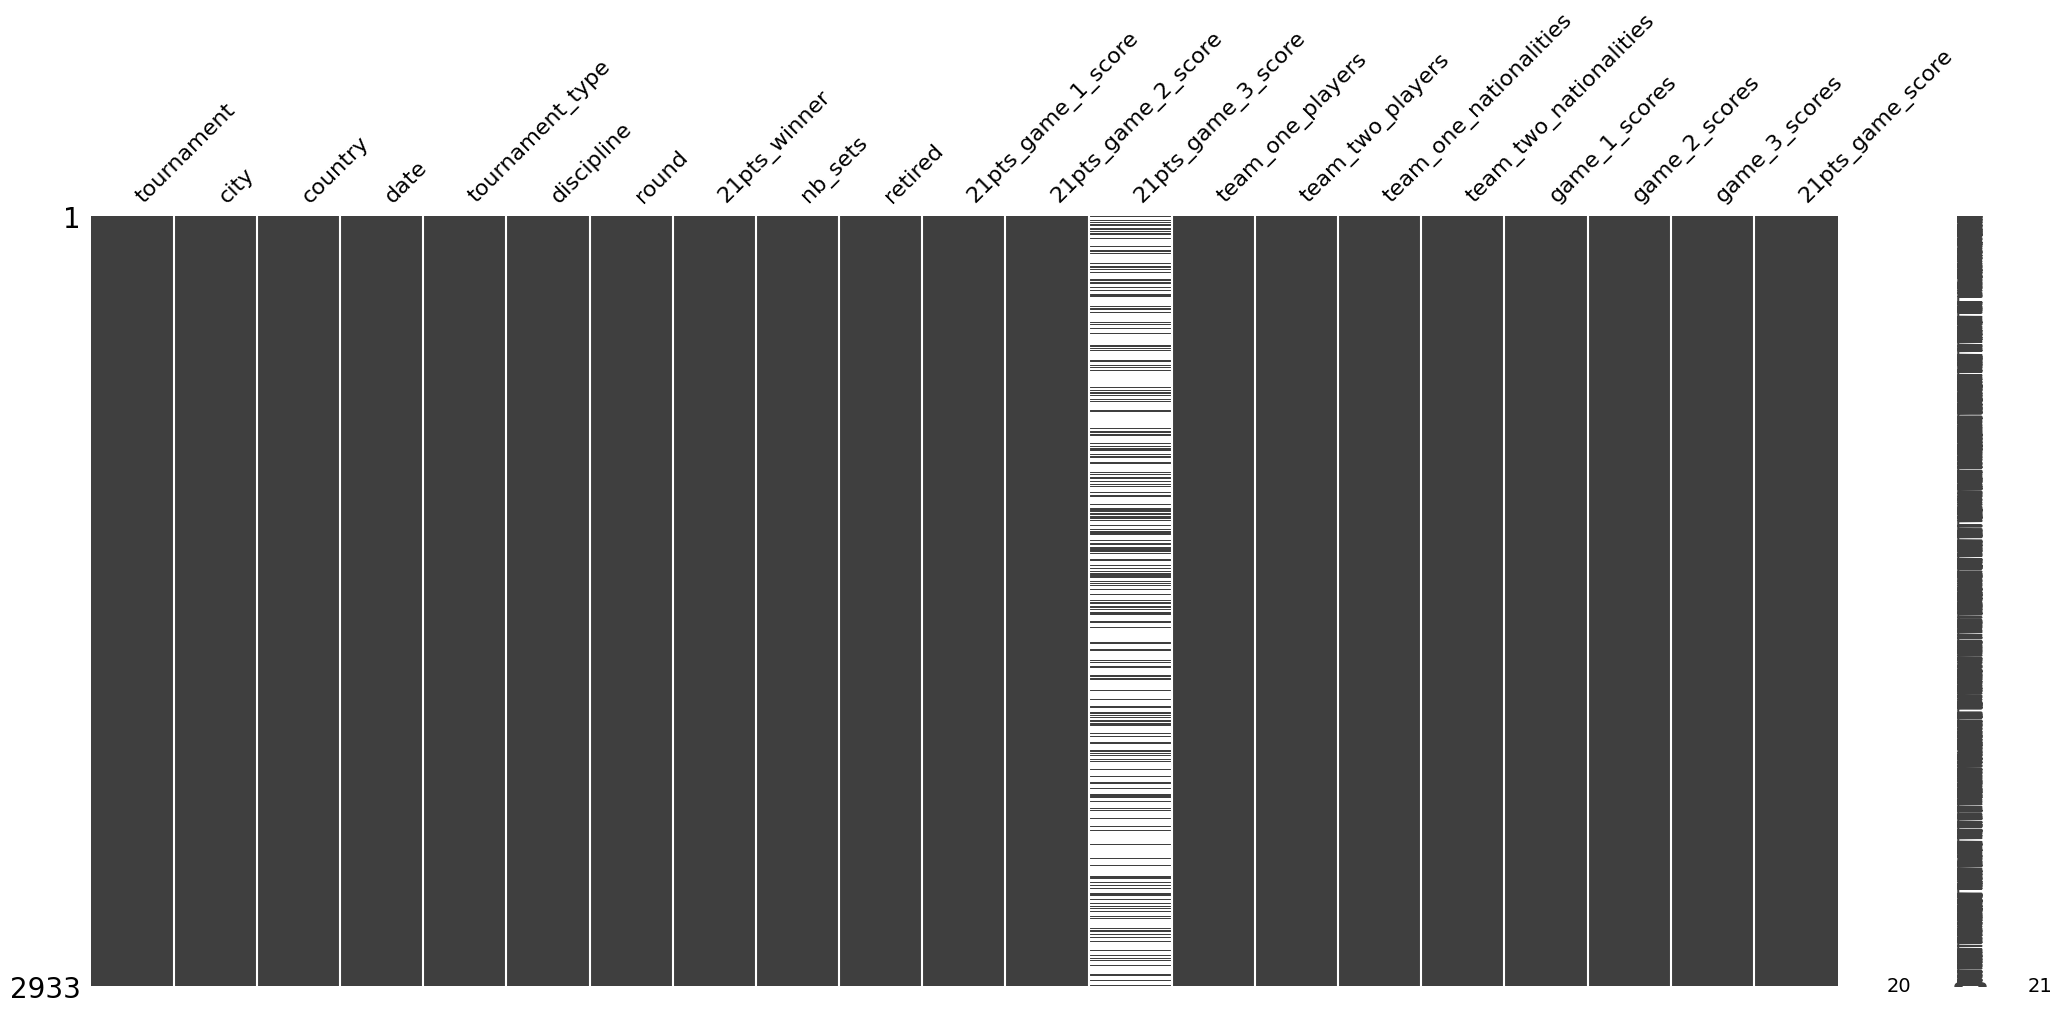

In [27]:
visualize_missing_value(ws)

In [28]:
#extract score for 11 points based system
ws = game_score_summary_11pts(ws)

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:12: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:22: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:33: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:36: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [29]:
#get winning team nationality for 21 points 
ws = get_winner_nationality(ws,pts_system='21')

#get winning team nationality for 11 points 
ws = get_winner_nationality(ws,pts_system='11')

In [30]:
#evaluate the result of scoring system change 
ws = evaluate_scoring_change(ws)

In [31]:
plot_pie(ws,chart_title="Proportion of Women's Singles Match Affected by Change in Scoring System")

In [32]:
plot_stacked_bar(df=ws,by='tournament_type',pct=True,
                 chart_title="Women's Single Match Evaluation for Scoring System Change in each Tournament Type")

In [33]:
#calculate net_win for Men's Singles
net_win_ws = extract_net_win(ws)
net_win_ws

,21pts_winner_nationalities,11pts_winner_nationalities,net_win,total_matches_involved,net_win_%
index,,,,,
TPE,21,14,-7,35,-20.00
SGP,8,1,-7,9,-77.78
CHN,30,24,-6,54,-11.11
GER,8,2,-6,10,-60.00
THA,30,25,-5,55,-9.09
JPN,40,36,-4,76,-5.26
USA,12,8,-4,20,-20.00
CAN,10,6,-4,16,-25.00
BUL,3,1,-2,4,-50.00


## Men's Doubles

In [34]:
#Men's Doubles
md = pd.read_csv('md.csv')

In [35]:
#filter retired match 
md = filter_retired(md)

#extract team nationality
md = extract_team_nationality(md)

#create player pair summary 
md = player_pair_summary(md)

#create game score
md = game_score_summary_21pts(md)

#simplify columns 
md = simplify_columns(md)

md

,tournament,city,country,date,tournament_type,discipline,round,21pts_winner,nb_sets,retired,...,21pts_game_2_score,21pts_game_3_score,game_1_scores,game_2_scores,game_3_scores,team_one_nationalities,team_two_nationalities,team_one_players,team_two_players,21pts_game_score
0,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MD,Qualification quarter final,1,3,False,...,15-21,21-9,"['0-0', '1-0', '1-1', '1-2', '1-3', '2-3', '3-...","['0-0', '0-1', '0-2', '1-2', '1-3', '1-4', '2-...","['0-0', '1-0', '2-0', '2-1', '2-2', '3-2', '3-...",HKG,THA,Wai Lun Ho/Chun Hei Tam,Parinyawat Thongnuam/Parinyawat Thongnuam,"[21-11, 15-21, 21-9]"
1,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MD,Qualification quarter final,1,2,False,...,21-18,NaN,"['0-0', '1-0', '2-0', '2-1', '2-2', '3-2', '4-...","['0-0', '1-0', '1-1', '2-1', '2-2', '2-3', '3-...",[],INA,THA,Rizky Kurniawan/Komandani Maytri Sugiarto,Tanawat Topattanakul/Tanawat Topattanakul,"[23-21, 21-18]"
2,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MD,Qualification quarter final,2,3,False,...,22-24,19-21,"['0-0', '0-1', '0-2', '1-2', '2-2', '2-3', '2-...","['0-0', '0-1', '0-2', '0-3', '1-3', '2-3', '2-...","['0-0', '1-0', '1-1', '2-1', '2-2', '3-2', '4-...",SGP,THA,Danny Bawa Chrisnanta/Yong Kai Terry Hee,Arkornnit Thaptimdong/Arkornnit Thaptimdong,"[21-13, 22-24, 19-21]"
3,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MD,Qualification quarter final,2,2,False,...,16-21,NaN,"['0-0', '0-1', '1-1', '1-2', '1-3', '1-4', '2-...","['0-0', '0-1', '1-1', '1-2', '2-2', '2-3', '2-...",[],IND,THA,Hari Kiran Chereddi/Ajay Kumar K.,Weeraphat Phakjarung/Weeraphat Phakjarung,"[12-21, 16-21]"
4,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,10-01-2018,HSBC BWF World Tour Super 300,MD,Round of 32,1,3,False,...,14-21,21-16,"['0-0', '1-0', '1-1', '1-2', '2-2', '3-2', '4-...","['0-0', '0-1', '0-2', '1-2', '1-3', '1-4', '2-...","['0-0', '0-1', '1-1', '1-2', '1-3', '2-3', '2-...",INA,HKG,Berry Angriawan/Hardianto Hardianto,Tak Ching Chang/Tak Ching Chang,"[21-12, 14-21, 21-16]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,MD,Quarter final,2,2,False,...,9-21,NaN,"['0-0', '1-0', '1-1', '1-2', '1-3', '2-3', '2-...","['0-0', '0-1', '1-1', '1-2', '1-3', '1-4', '2-...",[],GER,INA,Jones Ralfy Jansen/Peter Kaesbauer,Sabar Karyaman Gutama/Sabar Karyaman Gutama,"[15-21, 9-21]"
2773,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,MD,Quarter final,1,3,False,...,18-21,23-21,"['0-0', '0-1', '1-1', '2-1', '2-2', '3-2', '3-...","['0-0', '0-1', '1-1', '2-1', '2-2', '2-3', '3-...","['0-0', '1-0', '1-1', '2-1', '2-2', '3-2', '4-...",ENG,IND,Callum Hemming/Steven Stallwood,M.R. Arjun/M.R. Arjun,"[21-19, 18-21, 23-21]"
2774,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,MD,Semi final,1,3,False,...,21-16,21-13,"['0-0', '0-1', '0-2', '0-3', '1-3', '1-4', '2-...","['0-0', '1-0', '1-1', '1-2', '2-2', '3-2', '3-...","['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '5-...",ENG,INA,Ben Lane/Sean Vendy,Sabar Karyaman Gutama/Sabar Karyaman Gutama,"[10-21, 21-16, 21-13]"
2775,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,MD,Semi final,2,2,False,...,17-21,NaN,"['0-0', '0-1', '1-1', '1-2', '2-2', '2-3', '2-...","['0-0', '1-0', '1-1', '1-2', '1-3', '2-3', '2-...",[],ENG,IND,Callum Hemming/Steven Stallwood,Krishna Prasad Garaga/Krishna Prasad Garaga,"[17-21, 17-21]"


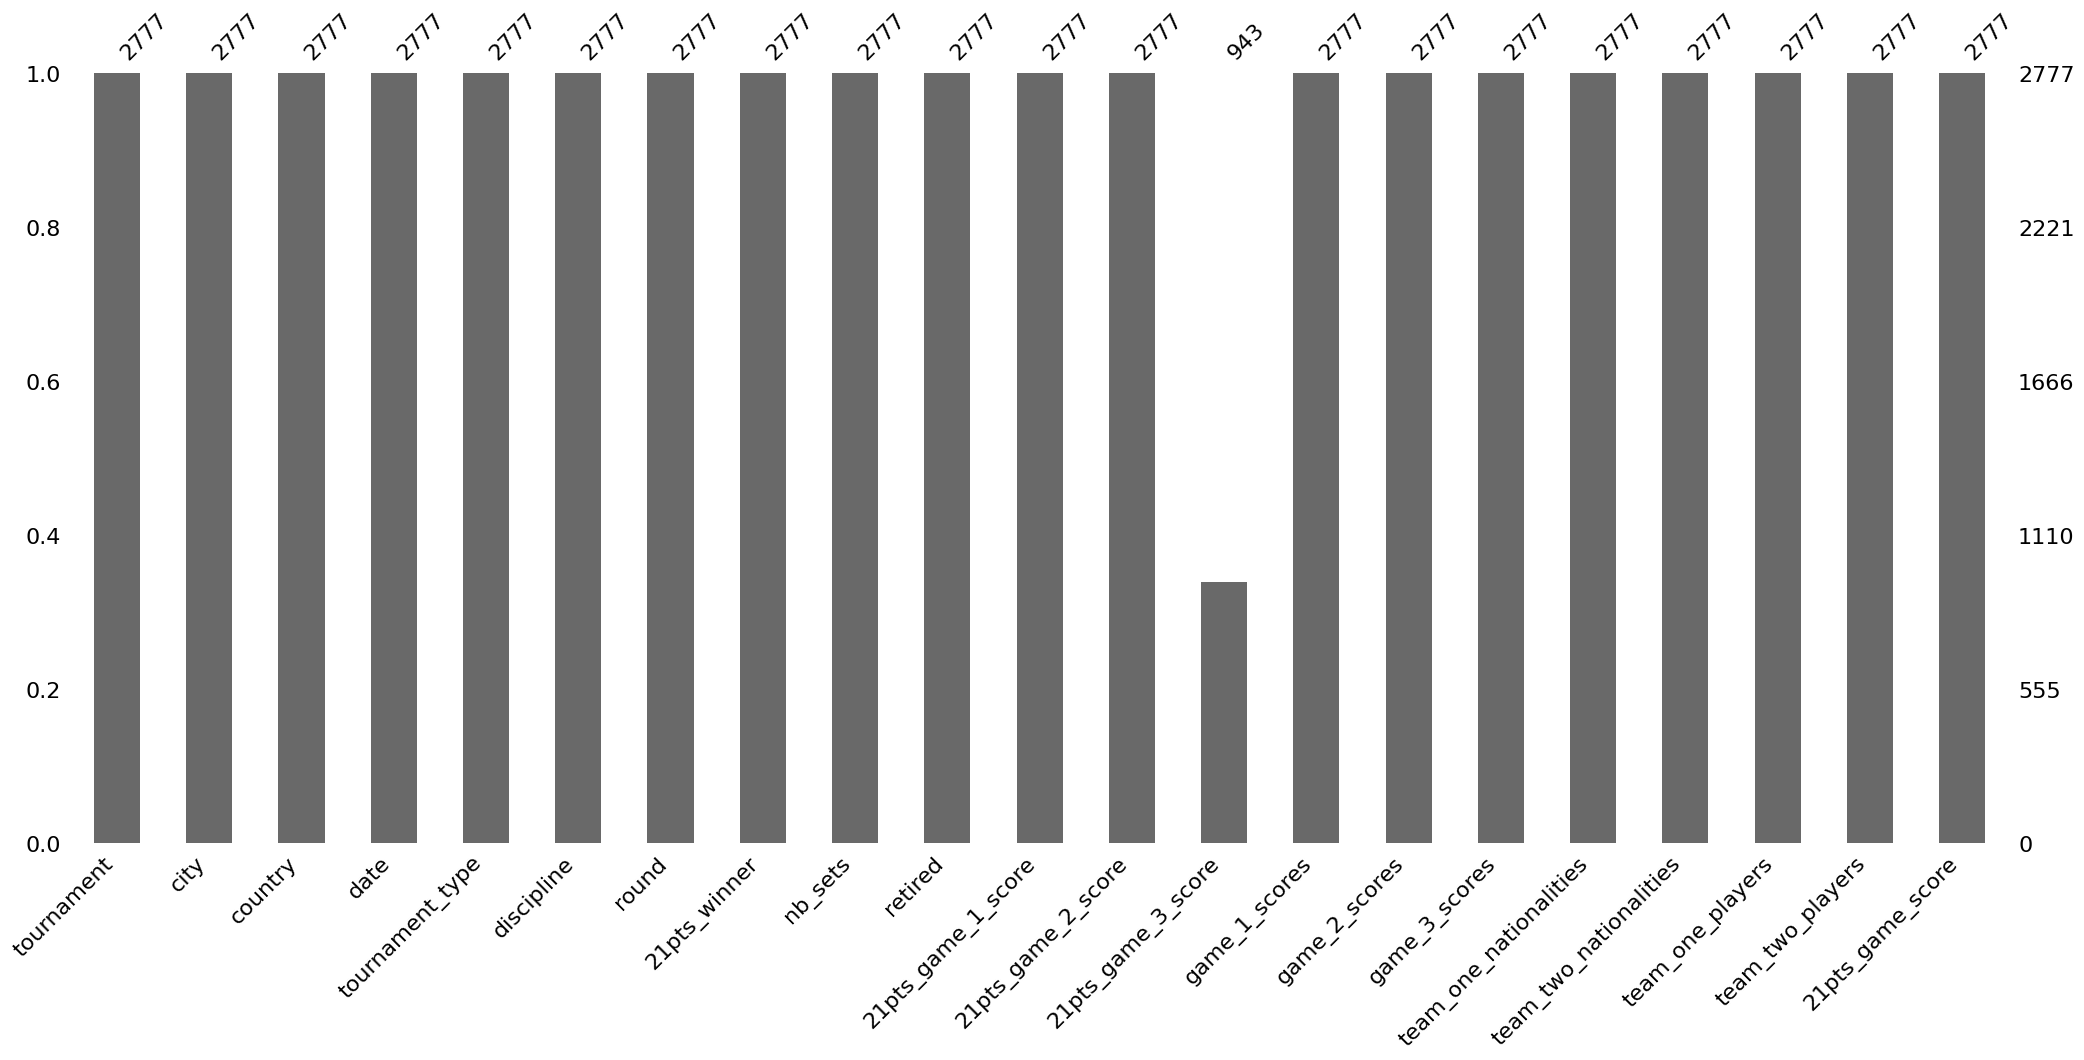

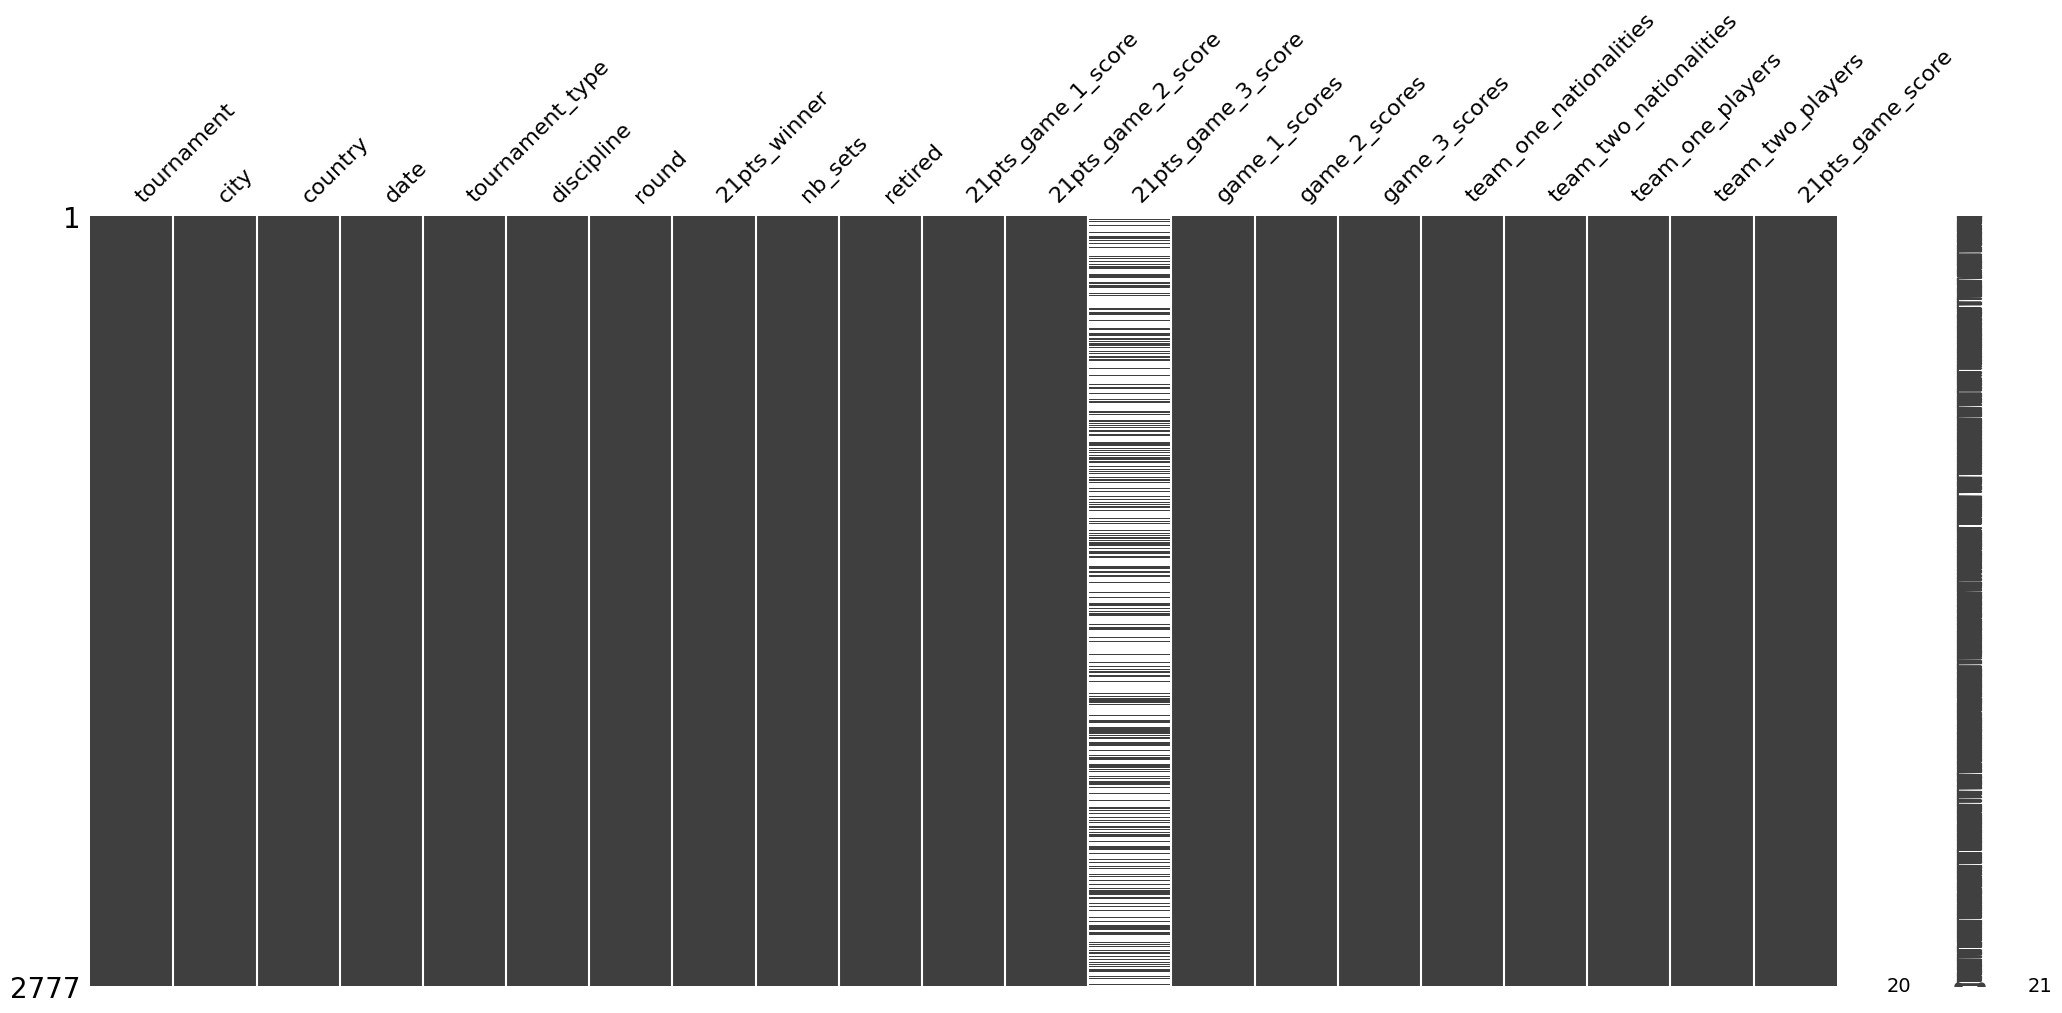

In [36]:
visualize_missing_value(md)

In [37]:
#extract score for 11 points based system
md = game_score_summary_11pts(md)

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:12: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:22: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:33: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:36: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [38]:
#get winning team nationality for 21 points 
md = get_winner_nationality(md,pts_system='21')

#get winning team nationality for 11 points 
md = get_winner_nationality(md,pts_system='11')

In [39]:
#evaluate the result of scoring system change 
md = evaluate_scoring_change(md)

In [40]:
plot_pie(md,chart_title="Proportion of Men's Doubles Match Affected by Change in Scoring System")

In [41]:
plot_stacked_bar(df=md,by='tournament_type',pct=True,
                 chart_title="Men's Double Match Evaluation for Scoring System Change in each Tournament Type")

In [42]:
#calculate net_win for Men's Doubles
net_win_md = extract_net_win(md)
net_win_md

,21pts_winner_nationalities,11pts_winner_nationalities,net_win,total_matches_involved,net_win_%
index,,,,,
INA,54,37,-17,91,-18.68
CHN,43,27,-16,70,-22.86
JPN,30,23,-7,53,-13.21
THA,14,10,-4,24,-16.67
MAS,40,38,-2,78,-2.56
ENG,11,9,-2,20,-10.00
SGP,3,2,-1,5,-20.00
KOR,24,23,-1,47,-2.13
IRL,1,1,0,2,0.00


## Women's Doubles

In [43]:
#Women's Singles
wd = pd.read_csv('wd.csv')

In [44]:
#filter retired match 
wd = filter_retired(wd)

#extract team nationality
wd = extract_team_nationality(wd)

#create player pair summary 
wd = player_pair_summary(wd)

#create game score
wd = game_score_summary_21pts(wd)

#simplify columns 
wd = simplify_columns(wd)

wd

,tournament,city,country,date,tournament_type,discipline,round,21pts_winner,nb_sets,retired,...,21pts_game_2_score,21pts_game_3_score,game_1_scores,game_2_scores,game_3_scores,team_one_nationalities,team_two_nationalities,team_one_players,team_two_players,21pts_game_score
0,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,WD,Qualification quarter final,2,3,False,...,21-16,18-21,"['0-0', '0-1', '0-2', '1-2', '1-3', '2-3', '2-...","['0-0', '0-1', '1-1', '1-2', '1-3', '1-4', '2-...","['0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '1-...",THA,THA,Sararat Chueboca/Suphapich Silprakob,Ploynaputh Anandechjurakun/Ploynaputh Anandech...,"[18-21, 21-16, 18-21]"
1,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,WD,Qualification quarter final,2,2,False,...,20-22,NaN,"['0-0', '1-0', '1-1', '1-2', '1-3', '1-4', '1-...","['0-0', '1-0', '2-0', '2-1', '2-2', '2-3', '3-...",[],THA,THA,Kunjira Khongdee/Nichakarn Kwandaeng,Chonnicha Charoenwat/Chonnicha Charoenwat,"[18-21, 20-22]"
2,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,WD,Qualification quarter final,2,2,False,...,7-21,NaN,"['0-0', '0-1', '1-1', '2-1', '2-2', '2-3', '2-...","['0-0', '0-1', '0-2', '1-2', '1-3', '1-4', '1-...",[],THA,THA,Phakhawadi Sukjai/Runshida Sukjai,Thidarat Kleebyeesoon/Thidarat Kleebyeesoon,"[11-21, 7-21]"
3,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,WD,Qualification quarter final,1,3,False,...,22-20,21-17,"['0-0', '0-1', '1-1', '1-2', '2-2', '2-3', '2-...","['0-0', '1-0', '1-1', '1-2', '2-2', '3-2', '3-...","['0-0', '1-0', '1-1', '2-1', '3-1', '3-2', '3-...",THA,THA,Manassiri Bowonwitthanakul/Suangsupa Suppasang,Maytinee Kunaanuvit/Maytinee Kunaanuvit,"[12-21, 22-20, 21-17]"
4,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,10-01-2018,HSBC BWF World Tour Super 300,WD,Round of 32,1,2,False,...,21-12,NaN,"['0-0', '1-0', '1-1', '2-1', '2-2', '2-3', '3-...","['0-0', '1-0', '2-0', '3-0', '4-0', '4-1', '4-...",[],THA,THA,Jongkolphan Kititharakul/Rawinda Prajongjai,Chonnicha Charoenwat/Chonnicha Charoenwat,"[21-11, 21-12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,WD,Quarter final,2,2,False,...,14-21,NaN,"['0-0', '0-1', '1-1', '2-1', '2-2', '3-2', '4-...","['0-0', '1-0', '2-0', '3-0', '4-0', '5-0', '5-...",[],DEN,BUL,Alexandra Bøje/Mette Poulsen,Gabriela Stoeva/Gabriela Stoeva,"[14-21, 14-21]"
2483,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,WD,Quarter final,1,2,False,...,21-15,NaN,"['0-0', '1-0', '1-1', '2-1', '2-2', '2-3', '3-...","['0-0', '1-0', '1-1', '1-2', '2-2', '2-3', '2-...",[],NED,DEN,Selena Piek/Cheryl Seinen,Maiken Fruergaard/Maiken Fruergaard,"[23-21, 21-15]"
2484,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,WD,Semi final,1,2,False,...,21-9,NaN,"['0-0', '1-0', '2-0', '2-1', '2-2', '3-2', '3-...","['0-0', '0-1', '1-1', '2-1', '2-2', '3-2', '4-...",[],THA,IND,Jongkolphan Kititharakul/Rawinda Prajongjai,Ashwini Ponnappa/Ashwini Ponnappa,"[21-18, 21-9]"
2485,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,WD,Semi final,2,3,False,...,14-21,9-21,"['0-0', '0-1', '1-1', '2-1', '3-1', '4-1', '4-...","['0-0', '0-1', '1-1', '1-2', '2-2', '3-2', '3-...","['0-0', '0-1', '0-2', '1-2', '1-3', '2-3', '2-...",NED,BUL,Selena Piek/Cheryl Seinen,Gabriela Stoeva/Gabriela Stoeva,"[21-10, 14-21, 9-21]"


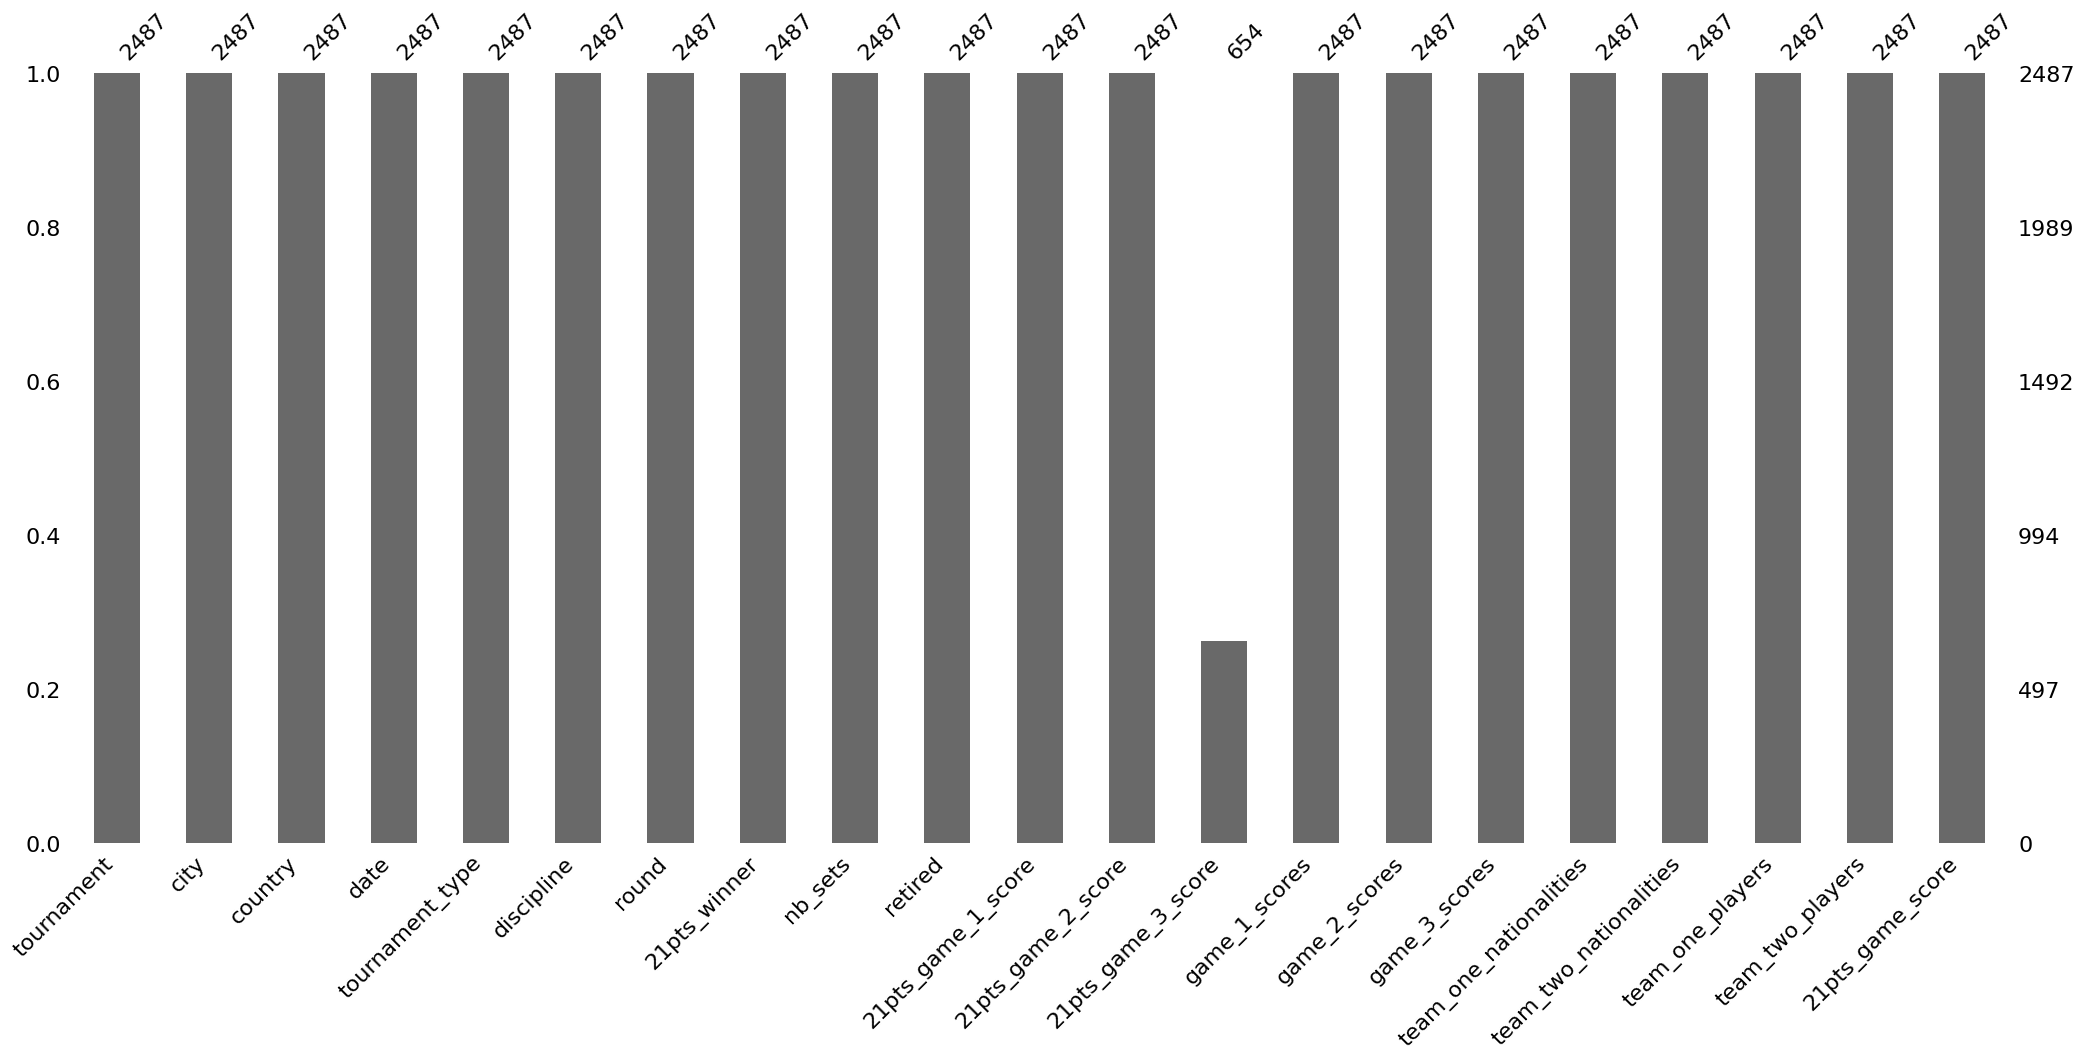

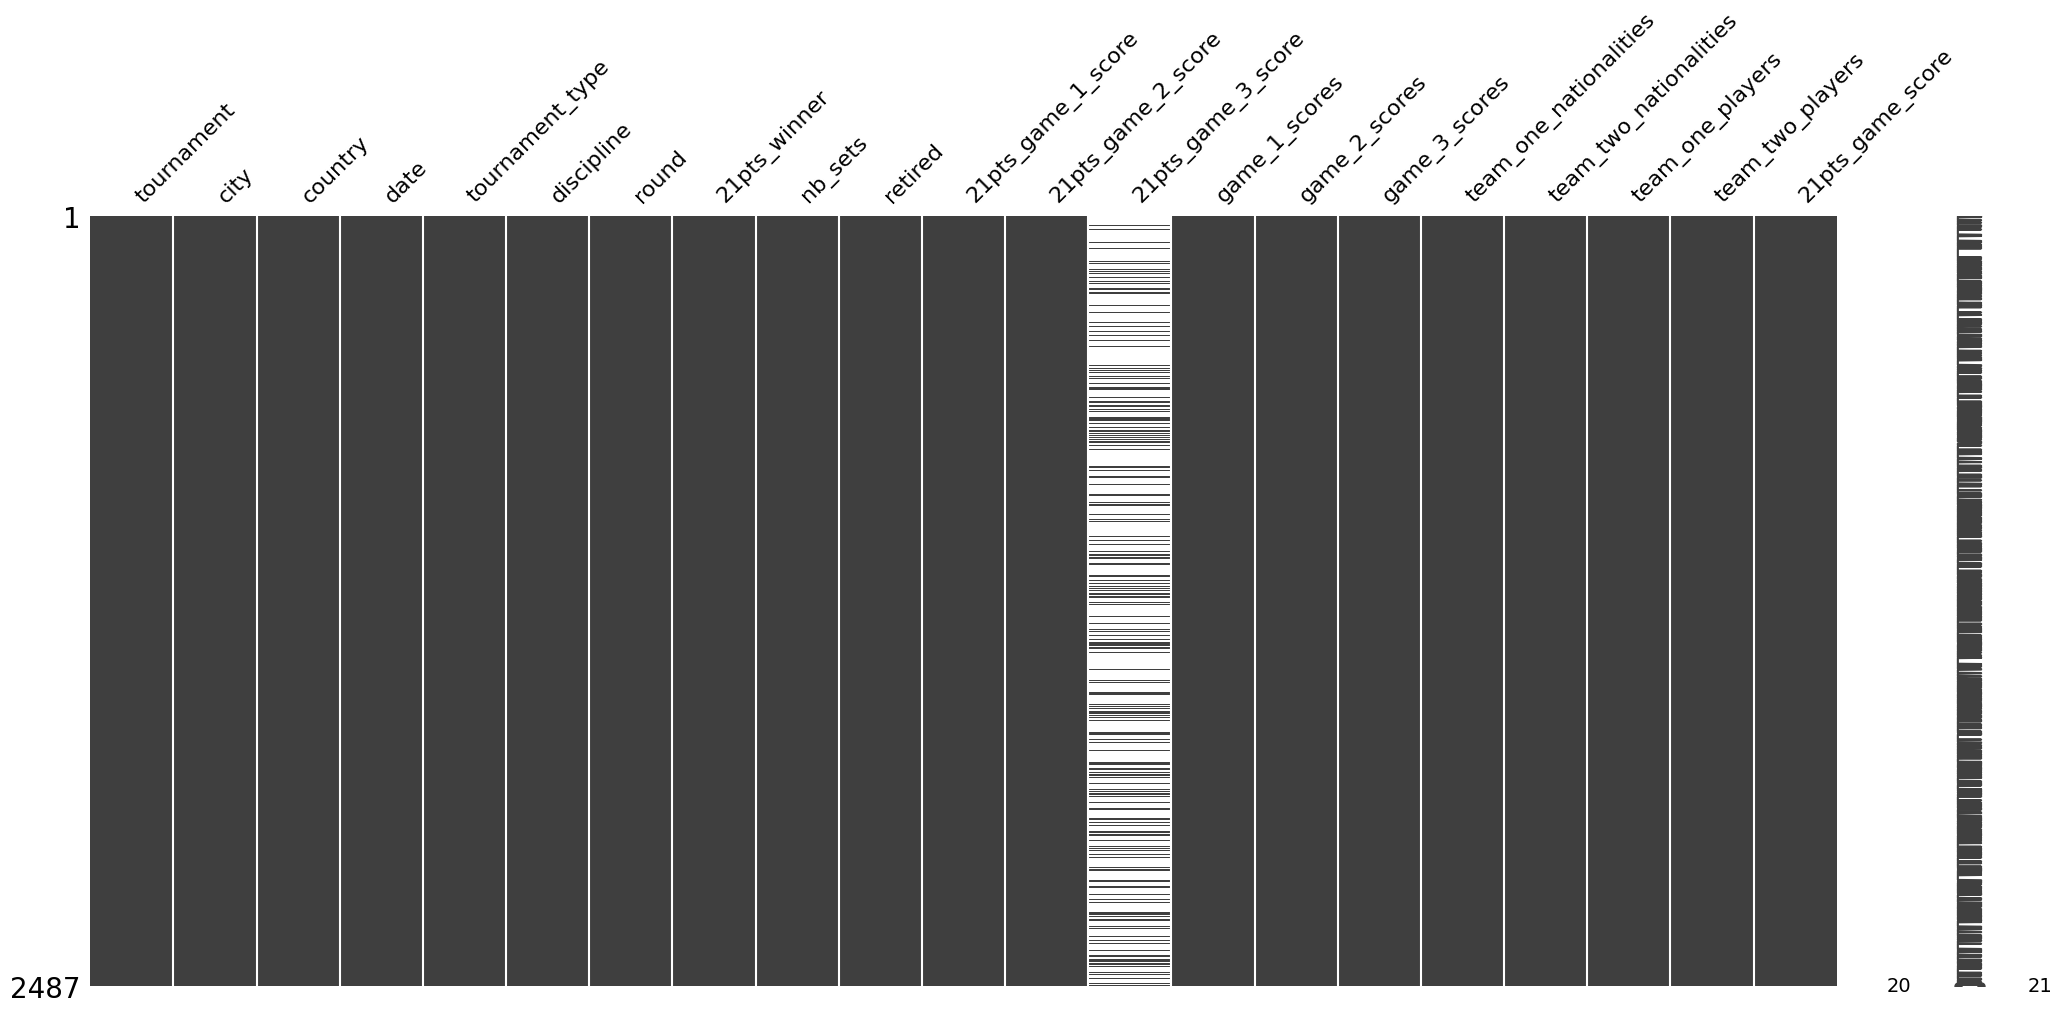

In [45]:
visualize_missing_value(wd)

In [46]:
#extract score for 11 points based system
wd = game_score_summary_11pts(wd)

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:12: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:22: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:33: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:36: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [47]:
#get winning team nationality for 21 points 
wd = get_winner_nationality(wd,pts_system='21')

#get winning team nationality for 11 points 
wd = get_winner_nationality(wd,pts_system='11')

In [48]:
#evaluate the result of scoring system change 
wd = evaluate_scoring_change(wd)

In [49]:
plot_pie(wd,chart_title="Proportion of Women's Doubles Match Affected by Change in Scoring System")

In [50]:
plot_stacked_bar(df=wd,by='tournament_type',pct=True,
                 chart_title="Women's Double Match Evaluation for Scoring System Change in each Tournament Type")

In [51]:
#calculate net_win for Women's Doubles
net_win_wd = extract_net_win(wd)
net_win_wd

,21pts_winner_nationalities,11pts_winner_nationalities,net_win,total_matches_involved,net_win_%
index,,,,,
JPN,34,22,-12,56,-21.43
ENG,5,1,-4,6,-66.67
TPE,14,10,-4,24,-16.67
BUL,5,1,-4,6,-66.67
KOR,27,24,-3,51,-5.88
INA,24,21,-3,45,-6.67
THA,14,12,-2,26,-7.69
NED,3,1,-2,4,-50.00
SUI,1,1,0,2,0.00


## Mixed Double

In [52]:
#Mixed Doubles
xd = pd.read_csv('xd.csv')

In [53]:
#filter retired match 
xd = filter_retired(xd)

#there are incomplete games I discovered in the earlier EDA
xd.drop(index=2100,inplace=True)
xd.reset_index(drop=False, inplace=True)
xd.drop(columns='index',inplace=True)

#extract team nationality
xd = extract_team_nationality(xd)

#create player pair summary 
xd = player_pair_summary(xd)

#create game score
xd = game_score_summary_21pts(xd)

#simplify columns 
xd = simplify_columns(xd)

xd

,tournament,city,country,date,tournament_type,discipline,round,21pts_winner,nb_sets,retired,...,21pts_game_2_score,21pts_game_3_score,game_1_scores,game_2_scores,game_3_scores,team_one_nationalities,team_two_nationalities,team_one_players,team_two_players,21pts_game_score
0,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,XD,Qualification quarter final,1,2,False,...,21-14,NaN,"['0-0', '1-0', '2-0', '3-0', '4-0', '4-1', '5-...","['0-0', '1-0', '1-1', '1-2', '2-2', '3-2', '4-...",[],HKG,THA,Shing Choi Yeung/Nga Ting Yeung,Apichasit Teerawiwat/Apichasit Teerawiwat,"[21-8, 21-14]"
1,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,XD,Qualification quarter final,2,2,False,...,18-21,NaN,"['0-0', '1-0', '1-1', '2-1', '3-1', '3-2', '3-...","['0-0', '0-1', '1-1', '2-1', '2-2', '3-2', '4-...",[],THA,THA,Chaloempon Charoenkitamorn/Rawimon Iamratanama...,Supak Jomkoh/Supak Jomkoh,"[17-21, 18-21]"
2,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,XD,Qualification quarter final,2,2,False,...,16-21,NaN,"['0-0', '1-0', '2-0', '2-1', '3-1', '3-2', '4-...","['0-0', '0-1', '0-2', '1-2', '1-3', '1-4', '1-...",[],THA,THA,Pakin Kuna-Anuvit/Supisara Paewsampran,Parinyawat Thongnuam/Parinyawat Thongnuam,"[21-23, 16-21]"
3,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,XD,Qualification quarter final,1,2,False,...,21-18,NaN,"['0-0', '1-0', '2-0', '3-0', '3-1', '4-1', '5-...","['0-0', '0-1', '1-1', '2-1', '3-1', '3-2', '3-...",[],THA,THA,Natchanon Tulamok/Natcha Saengchote,Charongrat Nobsamrong/Charongrat Nobsamrong,"[21-9, 21-18]"
4,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,XD,Round of 32,2,2,False,...,16-21,NaN,"['0-0', '0-1', '0-2', '1-2', '1-3', '1-4', '1-...","['0-0', '0-1', '1-1', '1-2', '2-2', '3-2', '4-...",[],RUS,FRA,Vitalij Durkin/Nina Vislova,Bastian Kersaudy/Bastian Kersaudy,"[15-21, 16-21]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,XD,Quarter final,1,3,False,...,18-21,21-16,"['0-0', '0-1', '1-1', '2-1', '2-2', '3-2', '4-...","['0-0', '1-0', '2-0', '3-0', '4-0', '5-0', '6-...","['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '5-...",DEN,DEN,Mathias Christiansen/Alexandra Bøje,Mathias Thyrri/Mathias Thyrri,"[21-4, 18-21, 21-16]"
2831,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,XD,Quarter final,2,2,False,...,11-21,NaN,"['0-0', '1-0', '1-1', '1-2', '1-3', '1-4', '1-...","['0-0', '1-0', '2-0', '2-1', '2-2', '2-3', '3-...",[],BEL,DEN,Jona Van Nieuwkerke/Lise Jaques,Niclas Nohr/Niclas Nohr,"[11-21, 11-21]"
2832,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,XD,Semi final,1,3,False,...,21-23,21-7,"['0-0', '0-1', '1-1', '2-1', '2-2', '3-2', '3-...","['0-0', '0-1', '1-1', '1-2', '2-2', '3-2', '3-...","['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '5-...",DEN,IND,Niclas Nohr/Amalie Magelund,Dhruv Kapila/Dhruv Kapila,"[21-9, 21-23, 21-7]"
2833,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,XD,Semi final,1,3,False,...,18-21,21-16,"['0-0', '0-1', '1-1', '2-1', '2-2', '3-2', '3-...","['0-0', '0-1', '1-1', '2-1', '2-2', '2-3', '3-...","['0-0', '1-0', '2-0', '3-0', '3-1', '4-1', '4-...",DEN,INA,Mathias Christiansen/Alexandra Bøje,Zachariah Josiahno Sumanti/Zachariah Josiahno ...,"[21-13, 18-21, 21-16]"


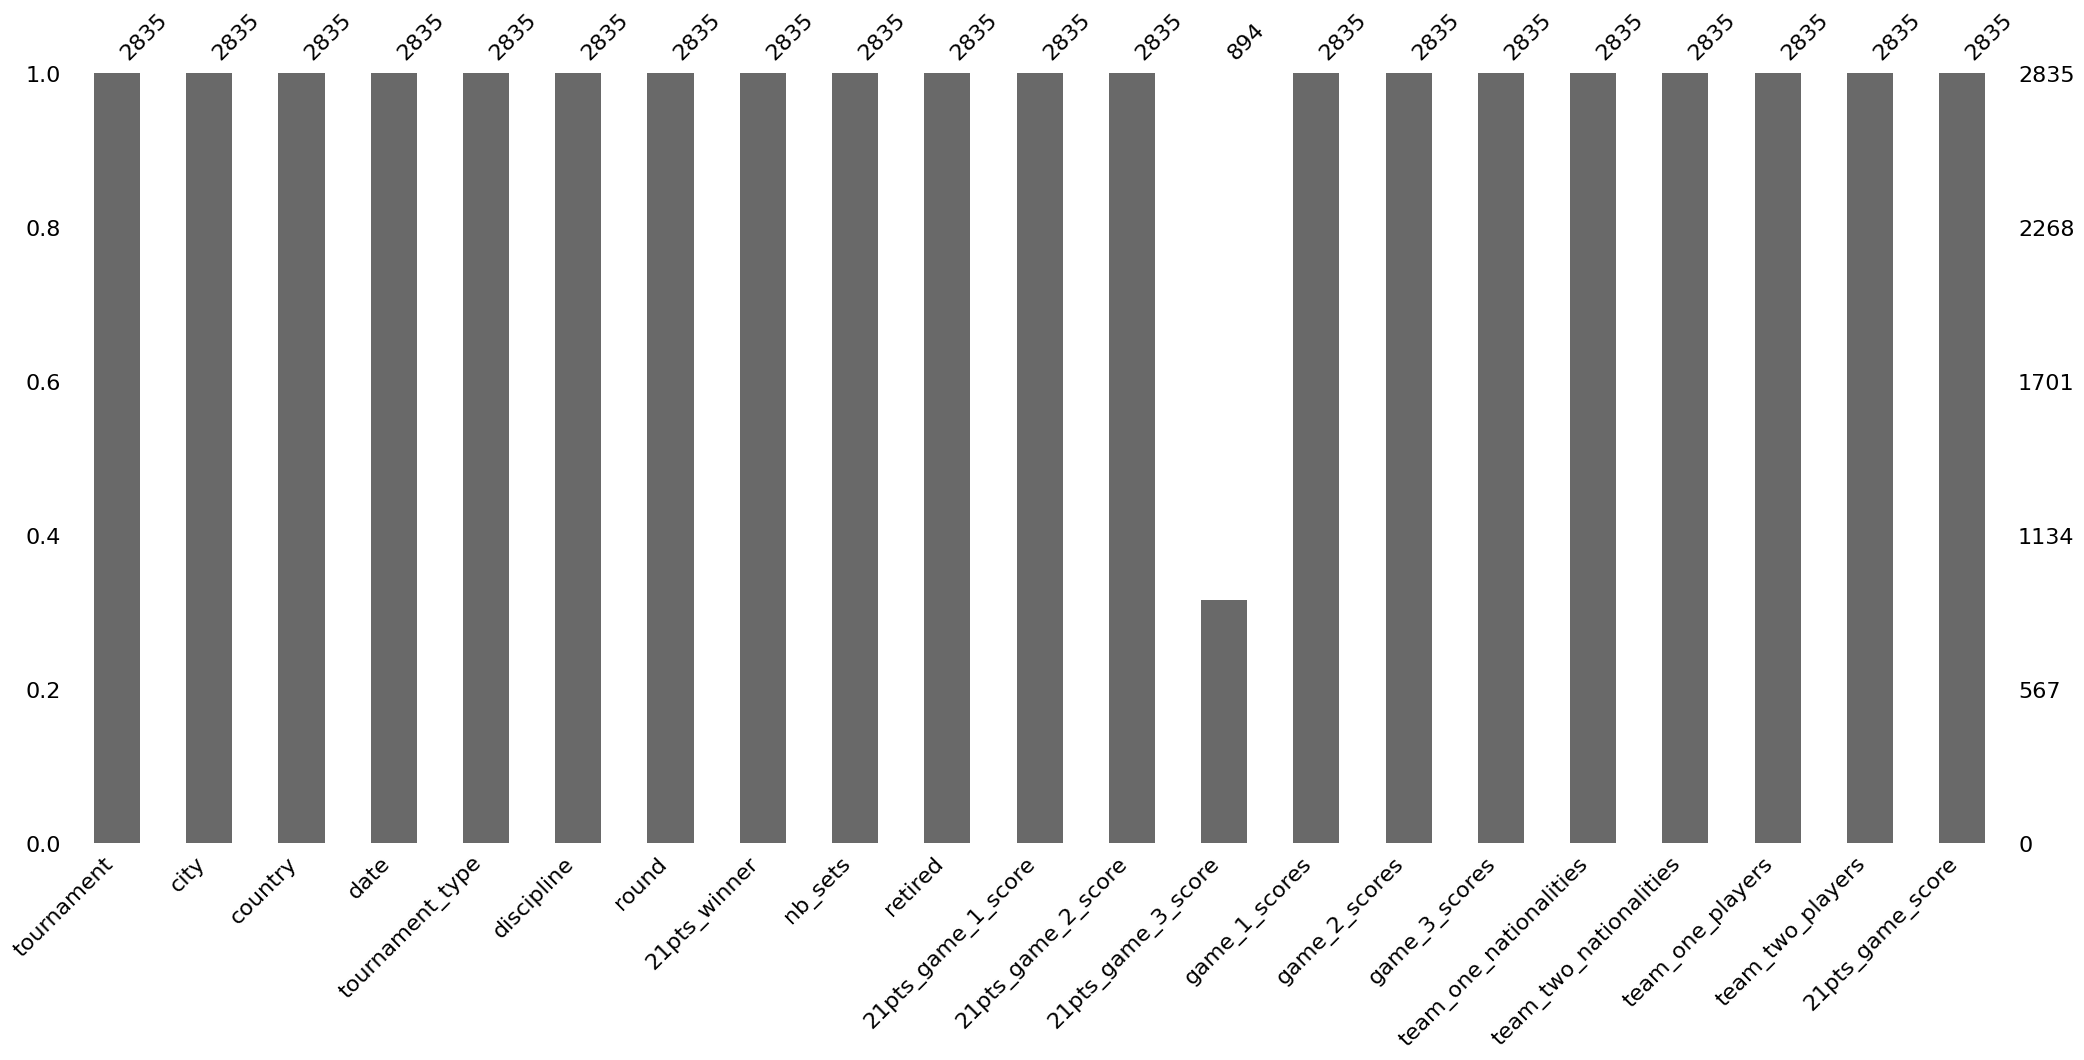

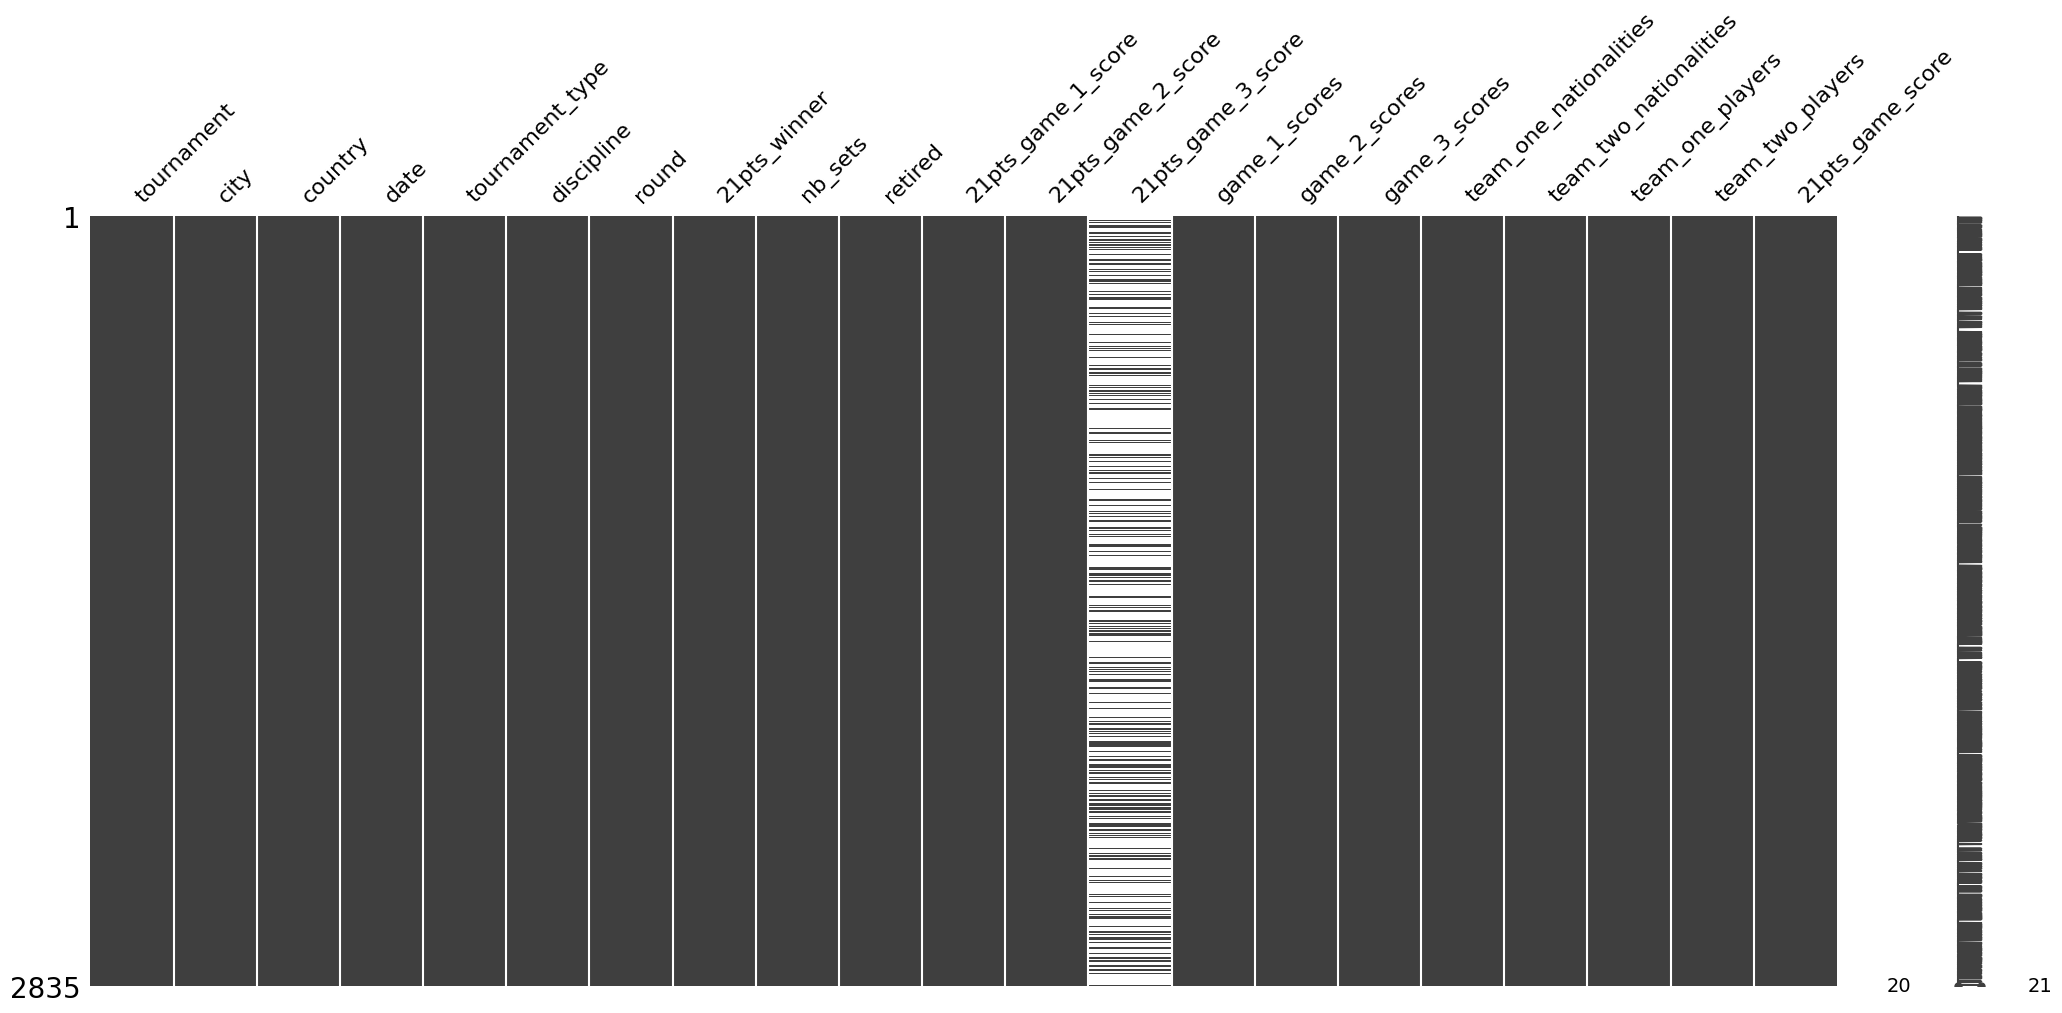

In [54]:
visualize_missing_value(xd)

In [55]:
#extract score for 11 points based system
xd = game_score_summary_11pts(xd)

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:12: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:22: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:36: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/r7/6bhw7cjs4d14765rwrwl5y480000gn/T/ipykernel_64884/3552447997.py:33: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [56]:
#get winning team nationality for 21 points 
xd = get_winner_nationality(xd,pts_system='21')

#get winning team nationality for 11 points 
xd = get_winner_nationality(xd,pts_system='11')

In [57]:
#evaluate the result of scoring system change 
xd = evaluate_scoring_change(xd)

In [58]:
plot_pie(xd,chart_title="Proportion of Mixed Doubles Match Affected by Change in Scoring System")

In [59]:
plot_stacked_bar(df=xd,by='tournament_type',pct=True,
                 chart_title="Mixed Double Match Evaluation for Scoring System Change in each Tournament Type")

In [60]:
#calculate net_win for Mixed Doubles
net_win_xd = extract_net_win(xd)
net_win_xd

,21pts_winner_nationalities,11pts_winner_nationalities,net_win,total_matches_involved,net_win_%
index,,,,,
INA,53,30,-23,83,-27.71
THA,23,15,-8,38,-21.05
JPN,16,9,-7,25,-28.00
ENG,17,12,-5,29,-17.24
FRA,9,6,-3,15,-20.00
DEN,14,13,-1,27,-3.70
IND,10,9,-1,19,-5.26
NED,8,8,0,16,0.00
KOR,15,15,0,30,0.00


## Combine All Data

In [61]:
#set the order of columns
cols_order = ['tournament', 'city', 'country', 'date', 'tournament_type',
       'discipline', 'round', '21pts_winner', 'nb_sets', 'retired',
       '21pts_game_1_score', '21pts_game_2_score', '21pts_game_3_score',
       'team_one_players', 'team_two_players', 'team_one_nationalities',
       'team_two_nationalities', 'game_1_scores', 'game_2_scores',
       'game_3_scores', '21pts_game_score', '11pts_game_1_score',
       '11pts_game_2_score', '11pts_game_3_score', '11pts_game_score',
       '11pts_winner', '21pts_winner_nationalities',
       '11pts_winner_nationalities', 'point_change_eval']

In [62]:
#Men's Singles
ms = ms[cols_order]

#Women's Singles
ws = ws[cols_order]

#Men's Doubles
md = md[cols_order]

#Women's Doubles
wd = wd[cols_order]

#Mixed Doubles
xd = xd[cols_order]

In [63]:
badminton_data = pd.concat([ms,ws,md,wd,xd])
badminton_data.reset_index(inplace = True, drop='index')

In [64]:
badminton_data

,tournament,city,country,date,tournament_type,discipline,round,21pts_winner,nb_sets,retired,...,game_3_scores,21pts_game_score,11pts_game_1_score,11pts_game_2_score,11pts_game_3_score,11pts_game_score,11pts_winner,21pts_winner_nationalities,11pts_winner_nationalities,point_change_eval
0,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,1,3,False,...,"['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '4-...","[11-21, 21-18, 21-9]",7-11,9-11,11-6,"[7-11, 9-11, 11-6]",2,MAS,THA,Changed
1,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,1,2,False,...,[],"[21-7, 21-18]",11-4,11-5,NaN,"[11-4, 11-5]",1,MAS,MAS,Unchanged
2,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,1,3,False,...,"['0-0', '1-0', '2-0', '3-0', '4-0', '4-1', '4-...","[21-16, 8-21, 23-21]",11-4,5-11,10-11,"[11-4, 5-11, 10-11]",2,THA,MAS,Changed
3,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,1,2,False,...,[],"[21-17, 21-7]",11-7,11-0,NaN,"[11-7, 11-0]",1,IND,IND,Unchanged
4,PRINCESS SIRIVANNAVARI Thailand Masters 2018,Bangkok,Thailand,09-01-2018,HSBC BWF World Tour Super 300,MS,Qualification round of 16,2,2,False,...,[],"[13-21, 13-21]",8-11,7-11,NaN,"[8-11, 7-11]",2,JPN,JPN,Unchanged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14717,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,XD,Quarter final,1,3,False,...,"['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '5-...","[21-4, 18-21, 21-16]",11-3,11-9,11-9,"[11-3, 11-9, 11-9]",1,DEN,DEN,Unchanged
14718,Orleans Masters 2021 (New Dates),Orleans,France,26-03-2021,BWF Tour Super 100,XD,Quarter final,2,2,False,...,[],"[11-21, 11-21]",6-11,7-11,NaN,"[6-11, 7-11]",2,DEN,DEN,Unchanged
14719,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,XD,Semi final,1,3,False,...,"['0-0', '1-0', '1-1', '2-1', '3-1', '4-1', '5-...","[21-9, 21-23, 21-7]",11-6,9-11,11-2,"[11-6, 9-11, 11-2]",1,DEN,DEN,Unchanged
14720,Orleans Masters 2021 (New Dates),Orleans,France,27-03-2021,BWF Tour Super 100,XD,Semi final,1,3,False,...,"['0-0', '1-0', '2-0', '3-0', '3-1', '4-1', '4-...","[21-13, 18-21, 21-16]",11-5,11-10,11-9,"[11-5, 11-10, 11-9]",1,DEN,DEN,Unchanged


In [65]:
plot_pie(badminton_data,chart_title="Proportion of All Match Affected by Change in Scoring System")

In [66]:
plot_stacked_bar(df=badminton_data,by='tournament_type',pct=True,
                 chart_title="All Match Evaluation for Scoring System Change in each Tournament Type")

In [67]:
#calculate net_win for all matches
net_win_all = extract_net_win(badminton_data)

#subset data for total match involved more than 100
net_win_all = net_win_all[net_win_all['total_matches_involved'] > 100]
net_win_all

,21pts_winner_nationalities,11pts_winner_nationalities,net_win,total_matches_involved,net_win_%
index,,,,,
CHN,184,145,-39,329,-11.85
JPN,149,115,-34,264,-12.88
THA,109,89,-20,198,-10.10
INA,172,157,-15,329,-4.56
MAS,129,126,-3,255,-1.18
KOR,99,99,0,198,0.00
DEN,90,96,6,186,3.23
TPE,120,136,16,256,6.25
IND,76,102,26,178,14.61


## Save to csv

In [68]:
#badminton_data.to_csv('badminton_data.csv')

## Interactive Chart 

In [69]:
!pip install chart-studio

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 630.5 kB/s eta 0:00:00a 0:00:01


In [70]:
import chart_studio
username='juanliong14'
api_key='VHeWCHGfIu1CQMEYxB6I'

chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [71]:
import chart_studio.plotly as py
import chart_studio.tools as tls

pie_all = px.pie(badminton_data, 
             values=badminton_data['point_change_eval'].value_counts(), 
             names=badminton_data['point_change_eval'].value_counts().index, 
             title='Proportion of All Match Affected by Change in Scoring System')

pie_all.show()

In [72]:
py.plot(pie_all, filename="All_match_eval_proportion", auto_open = True)

'https://plotly.com/~juanliong14/1/'

In [73]:
evaluation = badminton_data.groupby('discipline')['point_change_eval'].value_counts()
evaluation = evaluation.unstack('point_change_eval')

#reorder the columns 
col_name = ['Unchanged','Inconclusive','Changed']
evaluation = evaluation[col_name]

#order of display
custom_dict = {'MS': 0, 
               'WS': 1, 
               'MD': 2,
               'WD': 3,
               'XD': 4} 

evaluation = pd.DataFrame(evaluation.sort_index(key=lambda x:x.map(custom_dict)))
    
#rename the index
evaluation = evaluation.rename(index={"MS": "Men's Singles",
                                          "WS": "Women's Singles",
                                          "MD": "Men's Doubles",
                                          "WD": "Women's Doubles",
                                          "XD": "Mixed Doubles",})

#evaluation_percentage
evaluation_pct = evaluation.copy()
evaluation_pct['Unchanged'] = round(100*(evaluation['Unchanged']/(evaluation['Unchanged']+
                                    evaluation['Inconclusive']+evaluation['Changed'])),2)
evaluation_pct['Inconclusive'] = round(100*(evaluation['Inconclusive']/(evaluation['Unchanged']+
                                         evaluation['Inconclusive']+evaluation['Changed'])),2)
evaluation_pct['Changed'] = round(100*(evaluation['Changed']/(evaluation['Unchanged']+
                                        evaluation['Inconclusive']+evaluation['Changed'])),2)

discipline_prop = px.bar(evaluation_pct,
                          title = 'Match Evaluation for Scoring System Change in each Discipline',
                          labels={
                          "discipline": "Disciplines",
                          "value": "Percentage of Games"
                          })

discipline_prop.show()

In [74]:
py.plot(discipline_prop, filename="All_match_eval_per_discipline_proportion", auto_open = True)

'https://plotly.com/~juanliong14/3/'

In [75]:
evaluation = badminton_data.groupby('tournament_type')['point_change_eval'].value_counts()
evaluation = evaluation.unstack('point_change_eval')

#reorder the columns 
col_name = ['Unchanged','Inconclusive','Changed']
evaluation = evaluation[col_name]

#order of display
custom_dict = {'HSBC BWF World Tour Finals': 0, 
                   'HSBC BWF World Tour Super 1000': 1, 
                   'HSBC BWF World Tour Super 750': 2,
                   'HSBC BWF World Tour Super 500': 3,
                   'HSBC BWF World Tour Super 300': 4,
                   'HSBC BWF World Tour Super 100': 5} 

evaluation = pd.DataFrame(evaluation.sort_index(key=lambda x:x.map(custom_dict)))

#evaluation_percentage
evaluation_pct = evaluation.copy()
evaluation_pct['Unchanged'] = round(100*(evaluation['Unchanged']/(evaluation['Unchanged']+
                                    evaluation['Inconclusive']+evaluation['Changed'])),2)
evaluation_pct['Inconclusive'] = round(100*(evaluation['Inconclusive']/(evaluation['Unchanged']+
                                         evaluation['Inconclusive']+evaluation['Changed'])),2)
evaluation_pct['Changed'] = round(100*(evaluation['Changed']/(evaluation['Unchanged']+
                                        evaluation['Inconclusive']+evaluation['Changed'])),2)

tournament_prop = px.bar(evaluation_pct,
                          title = 'Match Evaluation for Scoring System Change in each Tournament Level',
                          labels={
                          "tournament_type": "Tournament Level",
                          "value": "Percentage of Games"
                          })
tournament_prop.show()

In [76]:
py.plot(tournament_prop, filename="All_match_eval_per_tournament_proportion", auto_open = True)

'https://plotly.com/~juanliong14/5/'

In [77]:
net_win_all = net_win_all.rename(index={'CHN':'China',
                                        'JPN':'Japan',
                                        'THA':'Thailand',
                                        'INA':'Indonesia',
                                        'MAS':'Malaysia',
                                        'KOR':'South Korea',
                                        'DEN':'Denmark',
                                        'TPE':'Chinese Taipei',
                                        'IND':'India'})

net_win_all

,21pts_winner_nationalities,11pts_winner_nationalities,net_win,total_matches_involved,net_win_%
index,,,,,
China,184,145,-39,329,-11.85
Japan,149,115,-34,264,-12.88
Thailand,109,89,-20,198,-10.10
Indonesia,172,157,-15,329,-4.56
Malaysia,129,126,-3,255,-1.18
South Korea,99,99,0,198,0.00
Denmark,90,96,6,186,3.23
Chinese Taipei,120,136,16,256,6.25
India,76,102,26,178,14.61


In [78]:
import plotly.graph_objects as go

net_win_change = go.Figure()


net_win_change.add_trace(go.Bar(name='Net Win',
                     x=list(net_win_all.index), 
                     y=list(net_win_all['net_win']),
                     text=list(net_win_all['net_win']),
                     textposition='auto',
                     marker=dict(color=list(net_win_all['net_win']),
                           colorscale='RdYlGn', cmid=0, colorbar=dict(title='Net Win'))
             ))

net_win_change.update_layout(title_text='Net Win Change for Each Nationality',
                             yaxis=dict(title='Net Win',
                                        titlefont_size=16,
                                        tickfont_size=14),
                             xaxis=dict(title='Nationalities',
                                        titlefont_size=16,
                                        tickfont_size=14)
                            )
        
net_win_change.show()

In [79]:
py.plot(net_win_change, filename="Net_win_change", auto_open = True)

'https://plotly.com/~juanliong14/7/'